In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder

<h1 style='text-align: center'}>Prediction of the Russian Housing Market</h1>

# 1. Introduction
The Russian housing market, shaped by its diverse regions and economic fluctuations, poses unique challenges for accurate property valuation and investment forecasting. In this project, I will leverage a comprehensive dataset provided by Sberbank, Russia's largest bank, to build sophisticated models that will predict and analyze real estate prices. By incorporating property-specific features and macroeconomic indicators, I will aim to provide a detailed understanding of the key factors that influence property values and market dynamics.


<b>`Main Goal:`</b> The primary objective of this project will be to predict the sale price `(price_doc)` of residential properties in Russia. I will use machine learning techniques to ensure that my model is robust and accurate. However, I will go beyond simple price prediction to explore additional models and targets that will offer a richer and more nuanced analysis of the housing market.

The project will focus on several key components to provide a comprehensive analysis of the Russian housing market:
1. `Price per Square Meter:` I will predict normalized property values to facilitate easier comparisons across regions, enhancing the understanding of relative value.
2. `Price Appreciation/Depreciation:` By estimating the annualized rate of value change, I will provide insights that inform long-term investment strategies and help investors anticipate future property performance.
3. `Time to Sale:` I will develop models to predict the duration a property will remain on the market, assisting in pricing and marketing strategies.
4. `Property Investment Classification:` I will categorize properties by their investment potential, helping investors identify lucrative opportunities quickly.
5. `Sale Likelihood:` I will classify properties based on their probability of selling within specified timeframes, offering real estate professionals a tool to prioritize their marketing efforts.
6. `Market Trend Classification:` I will assess whether local markets are **"Rising", "Stable" or "Falling"** providing strategic insights for homebuyers and investors

# 2. Reading the data
To begin, I’ll load the necessary datasets into my workspace. This step is essential for setting up the core data I’ll need throughout the project.
By reading the data into DataFrames, I’ll be ready to explore its structure and contents, which will help guide the data cleaning and preprocessing steps that follow.

In [2]:
train = pd.read_csv("train.csv/train.csv")
test = pd.read_csv("test.csv/test.csv")
macro = pd.read_csv("macro.csv/macro.csv")

Now, I’ll perform an initial inspection of both the `training` and `macro` datasets to understand their structure, dimensions, and variable types.

In [3]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
dimensions = {
    'Training dataset shape': train.shape,
    'Macro dataset shape': macro.shape
}
dimensions

{'Training dataset shape': (30471, 292), 'Macro dataset shape': (2484, 100)}

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [6]:
macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   timestamp                                   2484 non-null   object 
 1   oil_urals                                   2484 non-null   float64
 2   gdp_quart                                   2394 non-null   float64
 3   gdp_quart_growth                            2394 non-null   float64
 4   cpi                                         2453 non-null   float64
 5   ppi                                         2453 non-null   float64
 6   gdp_deflator                                2119 non-null   float64
 7   balance_trade                               2453 non-null   float64
 8   balance_trade_growth                        2394 non-null   float64
 9   usdrub                                      2481 non-null   float64
 10  eurrub     

The initial inspection shows that the training dataset is large, with 30,471 rows and 292 columns, while the macro dataset is smaller, with 2,484 rows and 100 columns. Both datasets are predominantly numerical, with some categorical columns that may require encoding.

# 3. Data formatting
 I’ll prepare and structure the datasets for seamless integration and analysis. First, I’ll ensure that date information in both datasets is standardized by converting the `timestamp` column to a datetime format. After this,<b> I’ll merge the training and macr datasets</b>  on the `timestamp` column, allowing me to enrich the training data with additional macroeconomic features. This data formatting step is crucial for aligning and consolidating the information, setting up a consistent foundation for the modeling phase.

In [7]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
macro['timestamp'] = pd.to_datetime(macro['timestamp'])

In [8]:
train['timestamp']

0       2011-08-20
1       2011-08-23
2       2011-08-27
3       2011-09-01
4       2011-09-05
           ...    
30466   2015-06-30
30467   2015-06-30
30468   2015-06-30
30469   2015-06-30
30470   2015-06-30
Name: timestamp, Length: 30471, dtype: datetime64[ns]

In [9]:
merged_df = pd.merge(train, macro, on="timestamp", how="left")

In [10]:
merged_df.shape

(30471, 391)

After merging, I checked the shape of the DataFrame to confirm success. The result is `(30471, 391)`, matching the original 30,471 rows and showing an increase in columns from 292 to 391. This confirms that the merge was successful, with the macro features correctly added by `timestamp`.

# 4. Missing values


In this step, I’ll analyze and handle missing values in the merged dataset to improve data quality for analysis and modeling. Missing values can impact the performance of machine learning models, so it's essential to assess the extent of missing data and make informed decisions about handling it. First, I’ll start by identifying which columns contain missing values and visualize the proportion of missing data in each of these columns.

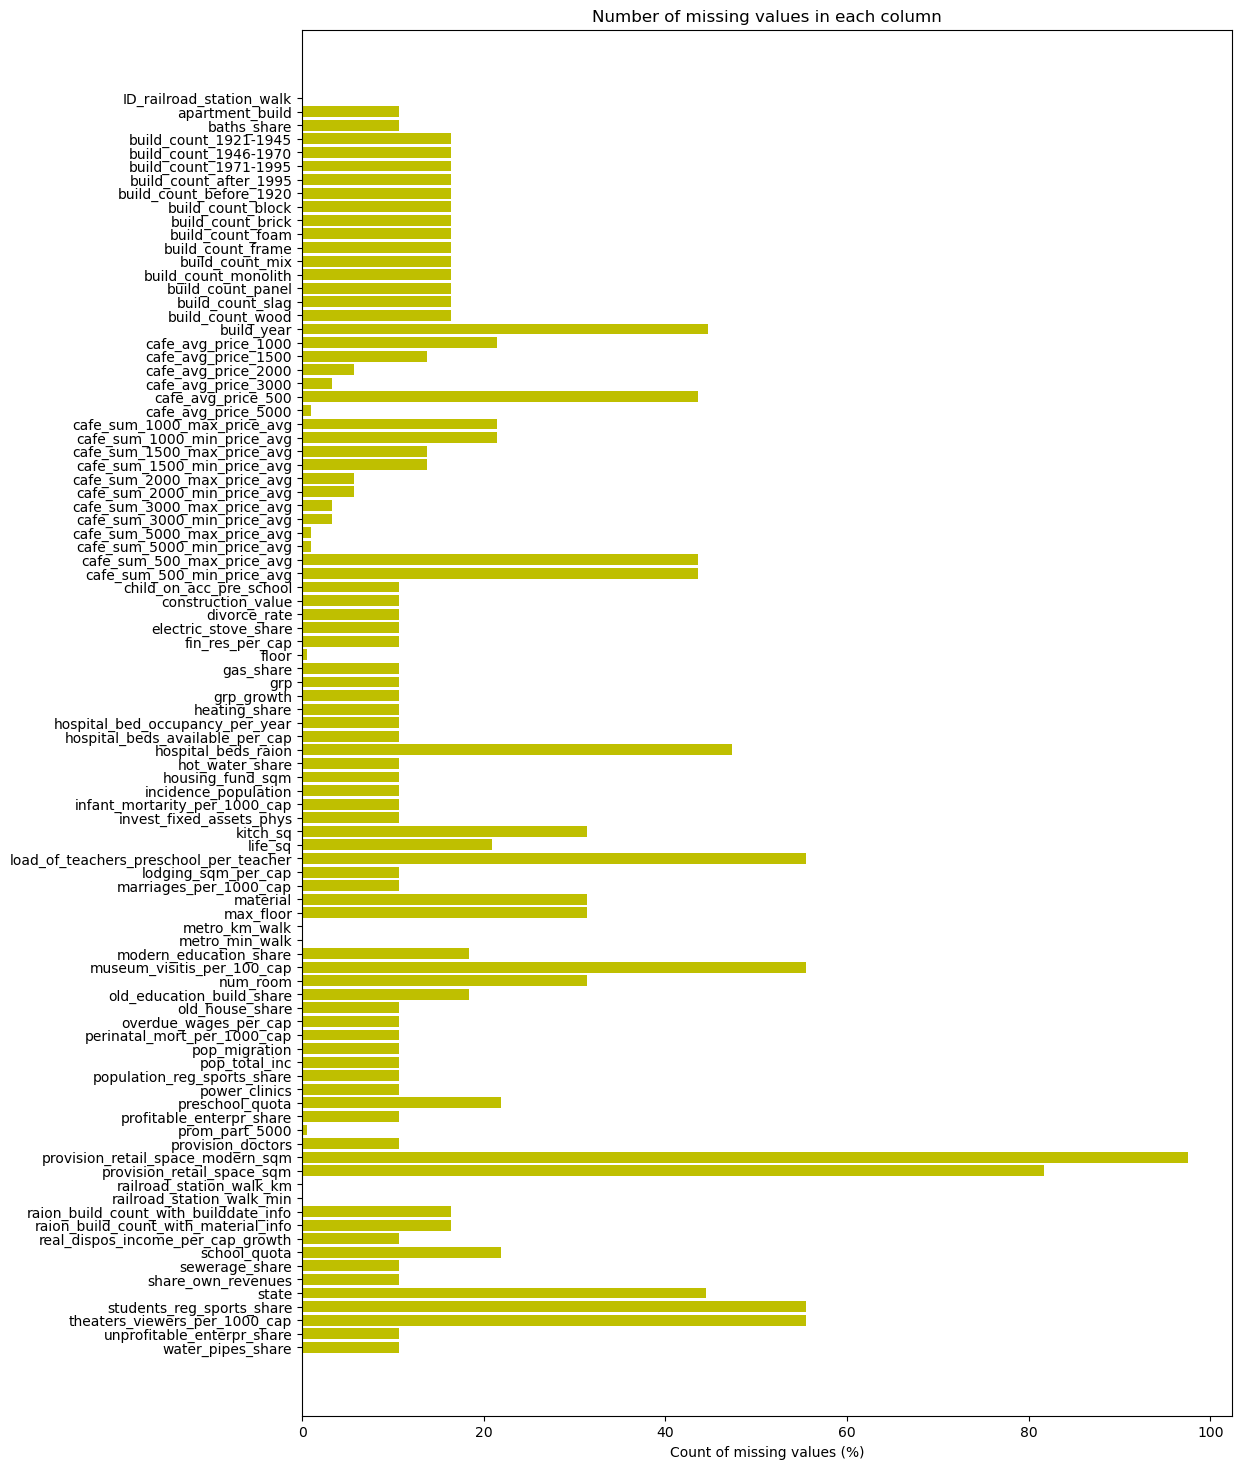

In [11]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='column_name', ascending=False)

ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values / merged_df.shape[0] * 100, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values (%)")
ax.set_title("Number of missing values in each column")
plt.show()

In [12]:
print(f"Number of columns with missing values: {len(missing_df)}")

Number of columns with missing values: 93


Next, I’ll set a threshold to decide which columns to keep based on the percentage of missing values. I’ve chosen a threshold of 50%, meaning that any column with more than 50% missing values will be removed. This helps to eliminate columns that are too incomplete to provide meaningful information, ensuring that the dataset remains relevant and manageable for further analysis.

In [13]:
threshold = merged_df.shape[0] * 0.5
threshold

15235.5

In [14]:
merged_df = merged_df.loc[:, merged_df.isnull().sum(axis=0) <= threshold]

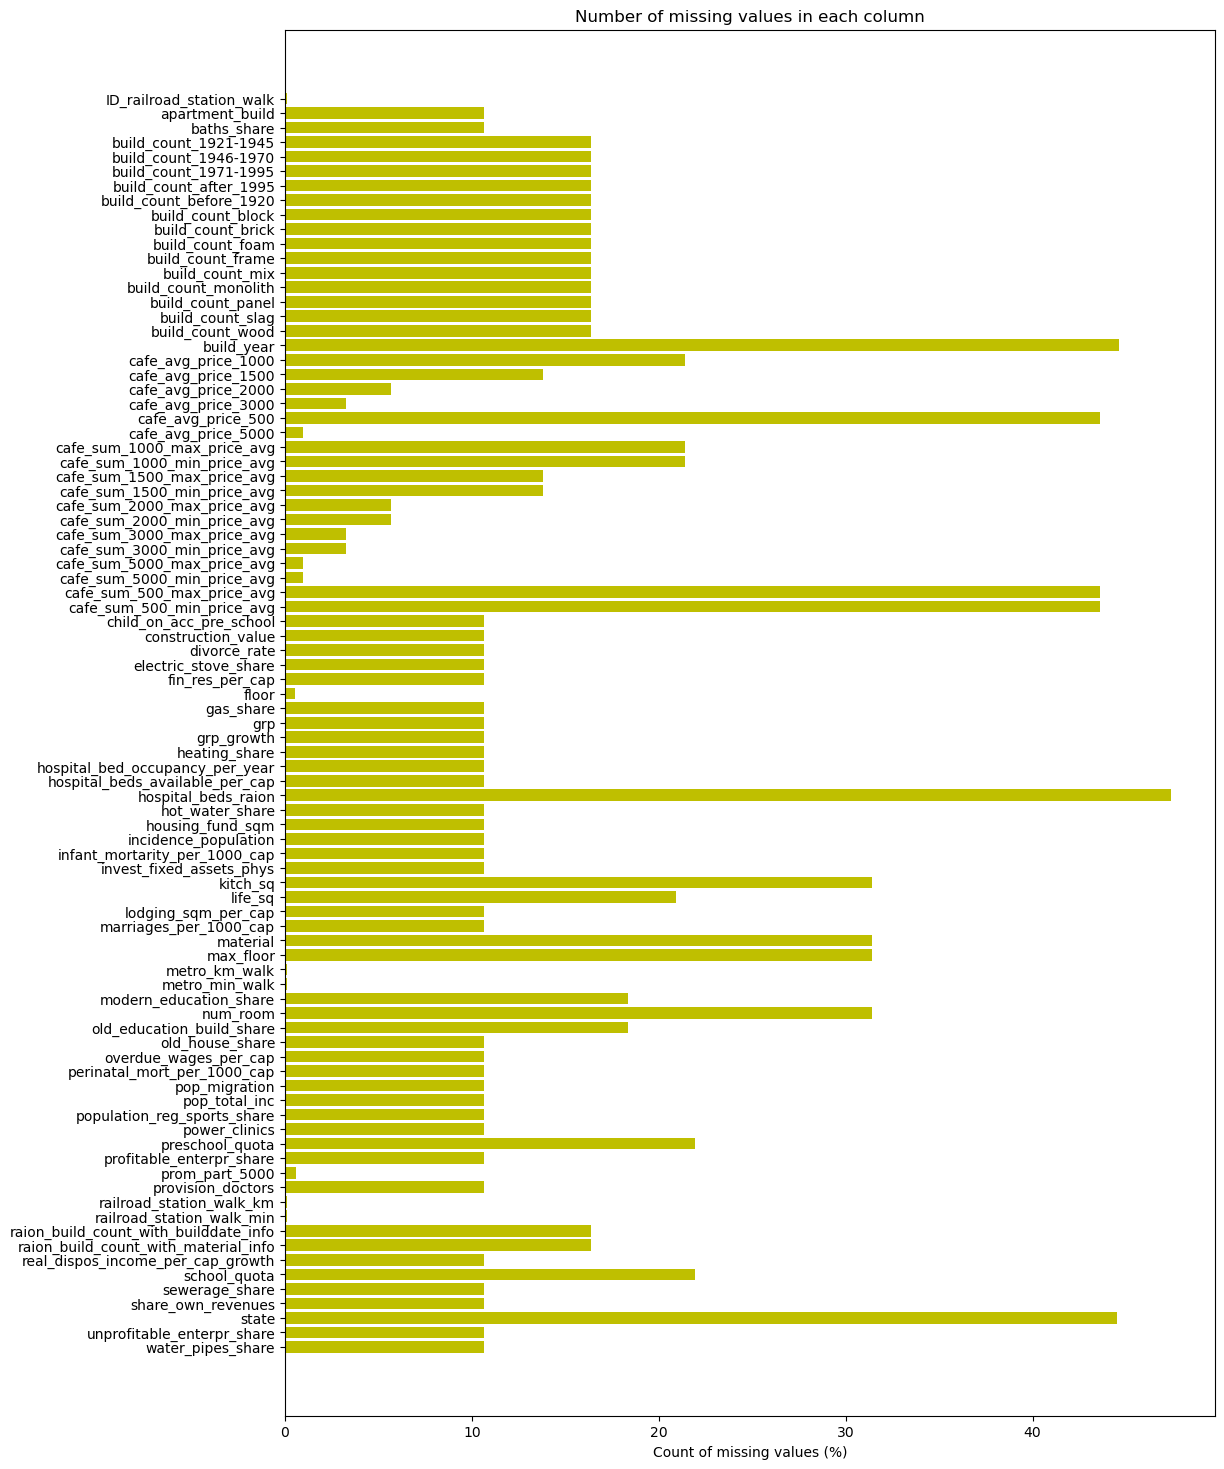

In [15]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='column_name', ascending=False)

ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values / merged_df.shape[0] * 100, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values (%)")
ax.set_title("Number of missing values in each column")
plt.show()

In [16]:
print(f"Number of columns with missing values: {len(missing_df)}")

Number of columns with missing values: 87


6 columns are dropped from the dataset.

Now, I’ll address the missing values in the dataset by filling them with appropriate values based on the type of data in each column.

In [17]:
columns_to_fill_with_zero = [
    'ID_railroad_station_walk',
    'apartment_build',
    'baths_share',
    'build_count_1921-1945',
    'build_count_1946-1970',
    'build_count_1971-1995',
    'build_count_after_1995',
    'build_count_before_1920',
    'build_count_block',
    'build_count_brick',
    'build_count_foam',
    'build_count_frame',
    'build_count_mix',
    'build_count_slag',
    'build_count_monolith',
    'build_count_panel',
    'build_count_wood',
    'cafe_avg_price_1000',
    'cafe_avg_price_1500',
    'cafe_avg_price_2000',
    'cafe_avg_price_3000',
    'cafe_avg_price_500',
    'cafe_avg_price_5000',
    'construction_value',
    'electric_stove_share',
    'gas_share',
    'heating_share',
    'sewerage_share', 
    'water_pipes_share', 
    'modern_education_share', 
    'school_quota',
    'preschool_quota',
    'hospital_bed_occupancy_per_year',
    'hospital_beds_available_per_cap',
    'hospital_beds_raion',
    'provision_doctors', 
    'railroad_station_walk_km',
    'railroad_station_walk_min', 
    'raion_build_count_with_builddate_info',
    'raion_build_count_with_material_info',
    'hot_water_share',
    'housing_fund_sqm',
    'cafe_sum_1000_max_price_avg',
    'cafe_sum_1000_min_price_avg',
    'cafe_sum_1500_max_price_avg',
    'cafe_sum_1500_min_price_avg',
    'cafe_sum_2000_max_price_avg',
    'cafe_sum_2000_min_price_avg',
    'cafe_sum_3000_max_price_avg',
    'cafe_sum_3000_min_price_avg',
    'cafe_sum_5000_max_price_avg',
    'cafe_sum_5000_min_price_avg',
    'cafe_sum_500_max_price_avg',
    'cafe_sum_500_min_price_avg',
    'profitable_enterpr_share', 
    'unprofitable_enterpr_share', 
    'share_own_revenues',
    'metro_km_walk',
    'metro_min_walk'
]

merged_df.loc[:, columns_to_fill_with_zero] = merged_df.loc[:, columns_to_fill_with_zero].fillna(0)

I have a problem with two of the columns that I want to fill with median values: `child_on_acc_pre_school` and `old_education_build_share`. These columns contain irregular numeric formats, such as commas instead of decimal points, and some non-numeric characters. 

To address this, I’ll first standardize the formatting by replacing commas with decimal points. Next, I’ll convert the columns to numeric, setting any entries that can't be converted (e.g., symbols or text) to `NaN`. Once the data is clean and in a numeric format, I’ll fill the missing values, including the `NaN` entries, with each column's median. 

This approach will ensure that these columns are consistent, usable for further analysis, and appropriately filled where data was missing or invalid.

In [18]:
merged_df.child_on_acc_pre_school.unique()

array(['#!', '7,311', '3,013', '16,765', nan], dtype=object)

In [19]:
merged_df.old_education_build_share.unique()

array([nan, '23,14', '25,47', '8,2517'], dtype=object)

In [20]:
columns_to_clean = ['child_on_acc_pre_school', 'old_education_build_share']

for col in columns_to_clean:
    merged_df[col] = merged_df[col].replace({',': '.'}, regex=True) 
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')  

In [21]:
merged_df.child_on_acc_pre_school.unique()

array([   nan,  7.311,  3.013, 16.765])

In [22]:
merged_df.old_education_build_share.unique()

array([    nan, 23.14  , 25.47  ,  8.2517])

I can fill them already!

In [23]:
columns_to_fill_with_median = [
    'fin_res_per_cap', 
    'grp_growth', 
    'invest_fixed_assets_phys',
    'overdue_wages_per_cap', 
    'real_dispos_income_per_cap_growth',
    'floor', 
    'max_floor', 
    'num_room', 
    'housing_fund_sqm',
    'kitch_sq', 
    'lodging_sqm_per_cap', 
    'old_education_build_share', 
    'old_house_share',
    'incidence_population', 
    'infant_mortarity_per_1000_cap',
    'perinatal_mort_per_1000_cap', 
    'marriages_per_1000_cap',
    'pop_total_inc', 
    'population_reg_sports_share',
    'divorce_rate',
    'grp',
    'power_clinics',
    'life_sq',
    'pop_migration',
    'prom_part_5000',
    'build_year',
    'child_on_acc_pre_school'
]

merged_df[columns_to_fill_with_median] = merged_df[columns_to_fill_with_median].fillna(merged_df[columns_to_fill_with_median].median())

In [24]:
columns_to_fill_with_mode = [
    'material',
    'state'
]

for column in columns_to_fill_with_mode:
    mode_value = merged_df[column].mode()[0]  
    merged_df[column] = merged_df[column].fillna(mode_value) 

In [25]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]

if len(missing_df) == 0:
    print("No columns with missing values.")

No columns with missing values.


# 5. Reducing Redundancy and Simplifying Feature Space

Correlations if 2 features are highly correlated, remove one of them, if there are too many left, do a PCA with 2, 3, 4, 5 components, and see which features have high impact in the pca components, and remove these with high values.

In this step, I will analyze correlations among the features to reduce redundancy and improve model efficiency by removing highly correlated features. Here's the plan:

1. Identify and Remove Highly Correlated Features: First, I’ll calculate correlation values among the numeric features. If any pairs of features have a high correlation (e.g., above a certain threshold), I'll remove one of the two to avoid redundant information in the dataset.
2. Principal Component Analysis (PCA): If there are still many features remaining, I’ll perform PCA to reduce dimensionality further. I'll try different numbers of components (e.g., 2, 3, 4, and 5) to see how much variance each set can capture. By examining the impact of individual features on the principal components, I can identify which features contribute most strongly and consider removing those with high influence in the components.

To begin, I’ll separate the dataset into numeric columns, which can be analyzed for correlations, and object or date columns, which will be excluded from this specific analysis.

However, first and foremost, I'll separate the `target variable (price_doc in my case)` from the rest of the dataset. The target variable should be excluded from the correlation analysis to avoid the risk of accidentally dropping it if it appears in a pair with another highly correlated feature. By isolating the target, I can safely analyze and handle correlations within the predictor features only, ensuring the target remains intact for our final predictive model.

In [26]:
target = merged_df['price_doc']

numeric_columns_df = merged_df.select_dtypes(include=['float64', 'int64']).drop(columns=['price_doc'])
object_dt_columns = merged_df.select_dtypes(include = ['object', 'datetime64[ns]'])

This setup enables me to focus on numeric features for correlation analysis and PCA, streamlining the process of feature selection and dimensionality reduction.

In [27]:
correlation_matrix = numeric_columns_df.corr()

In [28]:
correlation_matrix

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,turnover_catering_per_cap,seats_theather_rfmin_per_100000_cap,bandwidth_sports,population_reg_sports_share,apartment_build,apartment_fund_sqm
id,1.000000,0.021447,0.011919,-0.021096,0.041155,0.244193,-0.003688,-0.039330,0.000415,-0.009777,...,-0.762572,-0.800264,-0.679912,-0.574314,0.901647,0.410311,0.940352,0.828300,-0.413598,0.217225
full_sq,0.021447,1.000000,0.151406,0.089085,0.057650,0.017168,-0.002632,0.333761,0.009695,-0.039139,...,-0.023697,-0.021646,-0.029871,-0.029666,0.022352,0.020688,0.023268,0.012166,-0.024058,0.021801
life_sq,0.011919,0.151406,1.000000,0.032337,0.033413,0.014049,-0.002229,0.170746,0.003408,-0.048718,...,0.000281,-0.009083,-0.012123,-0.011736,0.010570,-0.004981,0.008694,0.010660,-0.007522,-0.004971
floor,-0.021096,0.089085,0.032337,1.000000,0.371492,-0.019545,0.000363,-0.002176,-0.007286,-0.088592,...,0.033539,0.005701,0.009160,0.005929,-0.012274,-0.029345,-0.022411,-0.012807,0.011149,-0.017556
max_floor,0.041155,0.057650,0.033413,0.371492,1.000000,0.057608,-0.000203,-0.016924,0.020689,-0.057017,...,-0.027545,-0.033569,-0.025232,-0.020310,0.037988,0.010843,0.038524,0.037430,-0.013110,0.001980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seats_theather_rfmin_per_100000_cap,0.410311,0.020688,-0.004981,-0.029345,0.010843,0.044859,-0.008081,0.012791,-0.005459,-0.068029,...,-0.875973,-0.146015,-0.662974,-0.683213,0.234711,1.000000,0.461790,-0.040981,-0.748824,0.952420
bandwidth_sports,0.940352,0.023268,0.008694,-0.022411,0.038524,0.231938,-0.004213,-0.031955,0.000226,-0.006874,...,-0.822460,-0.834571,-0.757305,-0.650597,0.949268,0.461790,1.000000,0.862399,-0.483892,0.260673
population_reg_sports_share,0.828300,0.012166,0.010660,-0.012807,0.037430,0.239475,-0.000693,-0.046353,0.002415,0.035345,...,-0.442357,-0.853927,-0.426415,-0.287859,0.930247,-0.040981,0.862399,1.000000,-0.072824,-0.255023
apartment_build,-0.413598,-0.024058,-0.007522,0.011149,-0.013110,-0.048282,0.002649,-0.023399,-0.002633,0.076875,...,0.666491,0.038768,0.918002,0.957666,-0.242753,-0.748824,-0.483892,-0.072824,1.000000,-0.678461


In [29]:
threshold = 0.8
highly_correlated_pairs = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_pairs.add(colname)

reduced_df = numeric_columns_df.drop(columns=highly_correlated_pairs)

In [30]:
numeric_columns_df.shape

(30471, 367)

In [31]:
reduced_df.shape

(30471, 115)

In [32]:
reduced_df = pd.concat([reduced_df, object_dt_columns, target], axis=1)

In [33]:
reduced_df.shape

(30471, 133)

In [34]:
reduced_df.to_csv('reduced_data.csv', index=False)

After performing correlation analysis, I identified and removed highly correlated features, which significantly reduced the dimensionality of the dataset. Initially, I had `367 numeric columns` (without the target variable), but after applying the correlation threshold, `I am left with 115 columns`. This reduction helps mitigate issues like multicollinearity and makes the dataset more manageable for further processing, including modeling.

After reducing redundancy among numeric features, I reintroduced the target variable `(price_doc)` along with object and datetime columns, which were temporarily excluded during the correlation analysis. By adding these back, I now have a complete dataset that includes `133 columns` (`from 385` in the beginning) — covering numeric features, categorical/date features, and the target variable. This comprehensive dataset provides a well-rounded foundation for EDA, ensuring that I capture the full range of information across different data types and can better understand patterns, relationships, and distributions in preparation for model building.

# 6. Exploratory Data Analysis (EDA)

## Target variable EDA

In this step, I’ll start by exploring the target variable, `price_doc`, to understand its distribution, check for any skewness or outliers, and decide if any transformations are needed. After that, I’ll look at the rest of the dataset to identify patterns, relationships between features, and any potential data issues. This will give me a clearer understanding of the data before moving on to modeling.

Let's visualize the distribution of the target variable using a histogram combined with a `Kernel Density Estimate (KDE)`. This will allow me to see how the prices are distributed—whether they are skewed, follow a normal distribution, or have any other noticeable patterns. Understanding the distribution of the target variable is an important step in preparing the data for further modeling.

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


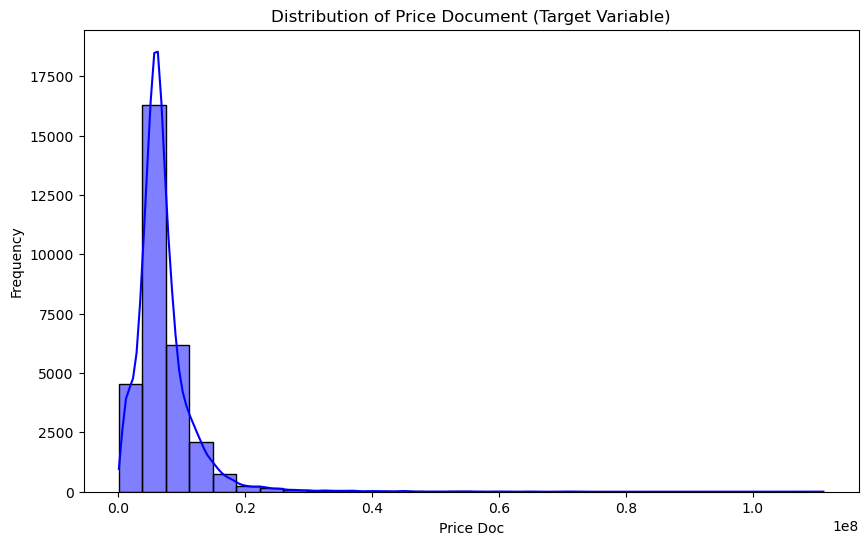

In [35]:
print(reduced_df['price_doc'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(reduced_df['price_doc'], kde=True, color='blue', bins=30)
plt.title("Distribution of Price Document (Target Variable)")
plt.xlabel("Price Doc")
plt.ylabel("Frequency")
plt.show()

Based on the histogram, several key insights can be drawn about its distribution.

**1. Right-Skewed Distribution:** <br>
The distribution of price_doc is highly skewed to the right, which means it exhibits positive skewness. Most of the data points (housing prices) are clustered towards the lower end of the price range. This indicates that the majority of properties are relatively inexpensive. However, there are a few much higher-priced properties that form a long tail on the right side of the distribution. This suggests that while most houses are priced similarly within a lower range, there are a few outliers in the form of very expensive properties.

**2. Presence of Outliers:** <br>
The histogram reveals the presence of extreme values that are far from the main cluster of data points. These outliers, which represent very high-priced properties, are important to identify as they can have a significant impact on the analysis. Extreme values may distort the model's ability to generalize and could lead to overfitting if not properly managed.

**3. Potential for Log Transformation:** <br>
Given the strong right skewness in the distribution, applying a log transformation to the price_doc variable may help to normalize the data. A log transformation is commonly used to reduce the effect of outliers and make the distribution more symmetrical. This could potentially improve the performance of certain machine learning models by reducing the impact of extreme values and helping models learn better from the data. A more normally distributed target variable can often lead to more accurate predictions.

In [36]:
reduced_df['log_price_doc'] = np.log(reduced_df['price_doc'] + 1)

In [37]:
reduced_df['log_price_doc'].describe()

count    30471.000000
mean        15.609483
std          0.604574
min         11.512935
25%         15.371548
50%         15.651990
75%         15.931766
max         18.526041
Name: log_price_doc, dtype: float64

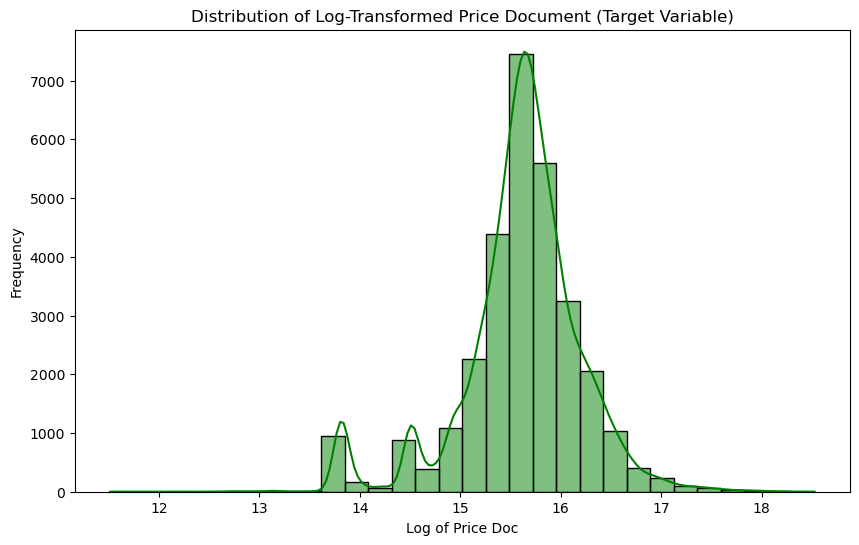

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(reduced_df['log_price_doc'], kde=True, color='green', bins=30)
plt.title("Distribution of Log-Transformed Price Document (Target Variable)")
plt.xlabel("Log of Price Doc")
plt.ylabel("Frequency")
plt.show()

After the log transformation, the distribution of `price_doc` has become more symmetric and less skewed, with a more bell-shaped curve. The concentration of housing prices is now more clearly defined around the range of 15 to 16, whereas the original distribution had a heavier concentration in lower price ranges. While the right tail has been reduced, there is still a slight tail, indicating the presence of some high-priced properties. Overall, the transformation has improved the distribution, making it more suitable for modeling, but the remaining tail suggests that extreme values still need attention.

Trimming Outliers using IQR:

Original data size: 30471
Trimmed data size: 27787


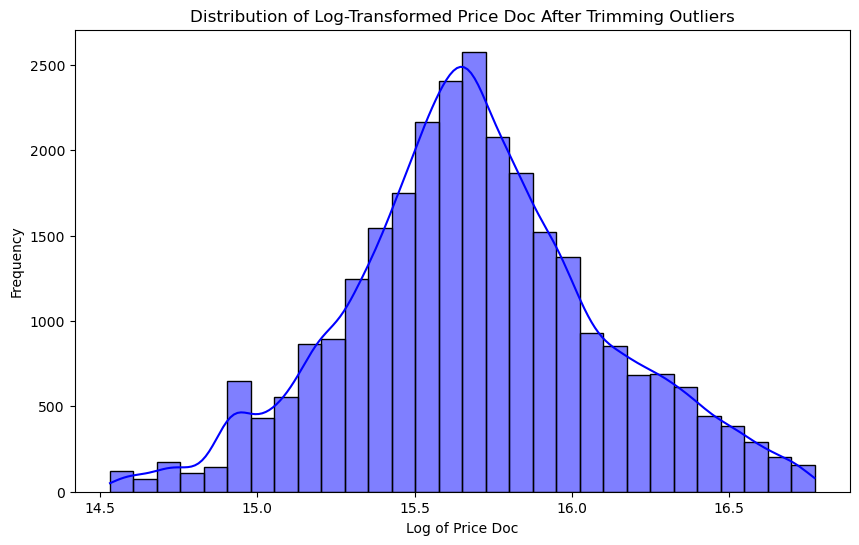

In [39]:
Q1 = reduced_df['log_price_doc'].quantile(0.25)
Q3 = reduced_df['log_price_doc'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

reduced_df_trimmed = reduced_df[(reduced_df['log_price_doc'] >= lower_bound) & (reduced_df['log_price_doc'] <= upper_bound)]

print(f"Original data size: {reduced_df.shape[0]}")
print(f"Trimmed data size: {reduced_df_trimmed.shape[0]}")

plt.figure(figsize=(10, 6))
sns.histplot(reduced_df_trimmed['log_price_doc'], kde=True, color='blue', bins=30)
plt.title("Distribution of Log-Transformed Price Doc After Trimming Outliers")
plt.xlabel("Log of Price Doc")
plt.ylabel("Frequency")
plt.show()

## Other аnalysis

After completing the EDA for the target variable, I will now focus on identifying the features most strongly correlated with `price_doc` and conduct EDA on these key features.

In [40]:
encoded_df = pd.get_dummies(reduced_df)

top_20_features = encoded_df.corr()['price_doc'].nlargest(21)

top_20_df = encoded_df[top_20_features.index[1:]]

In [41]:
top_20_df.columns

Index(['log_price_doc', 'num_room', 'full_sq', 'sport_objects_raion',
       'build_count_brick', 'cafe_sum_1000_min_price_avg',
       'cafe_sum_1500_min_price_avg', 'sport_count_1000', 'market_count_5000',
       'healthcare_centers_raion', 'cafe_sum_500_min_price_avg',
       'hospital_beds_raion', 'mosque_count_5000',
       'cafe_count_1000_price_high', 'university_top_20_raion',
       'leisure_count_500', 'cafe_sum_2000_min_price_avg',
       'build_count_monolith', 'culture_objects_top_25_yes', 'life_sq'],
      dtype='object')

I will start with histograms. This will allow me to visually assess the distribution patterns, skewness, and potential outliers for each feature. By understanding these characteristics, I can identify the need for any transformations or adjustments for extreme values. This initial analysis will provide a foundation for deeper exploration of how these features relate to the target variable.

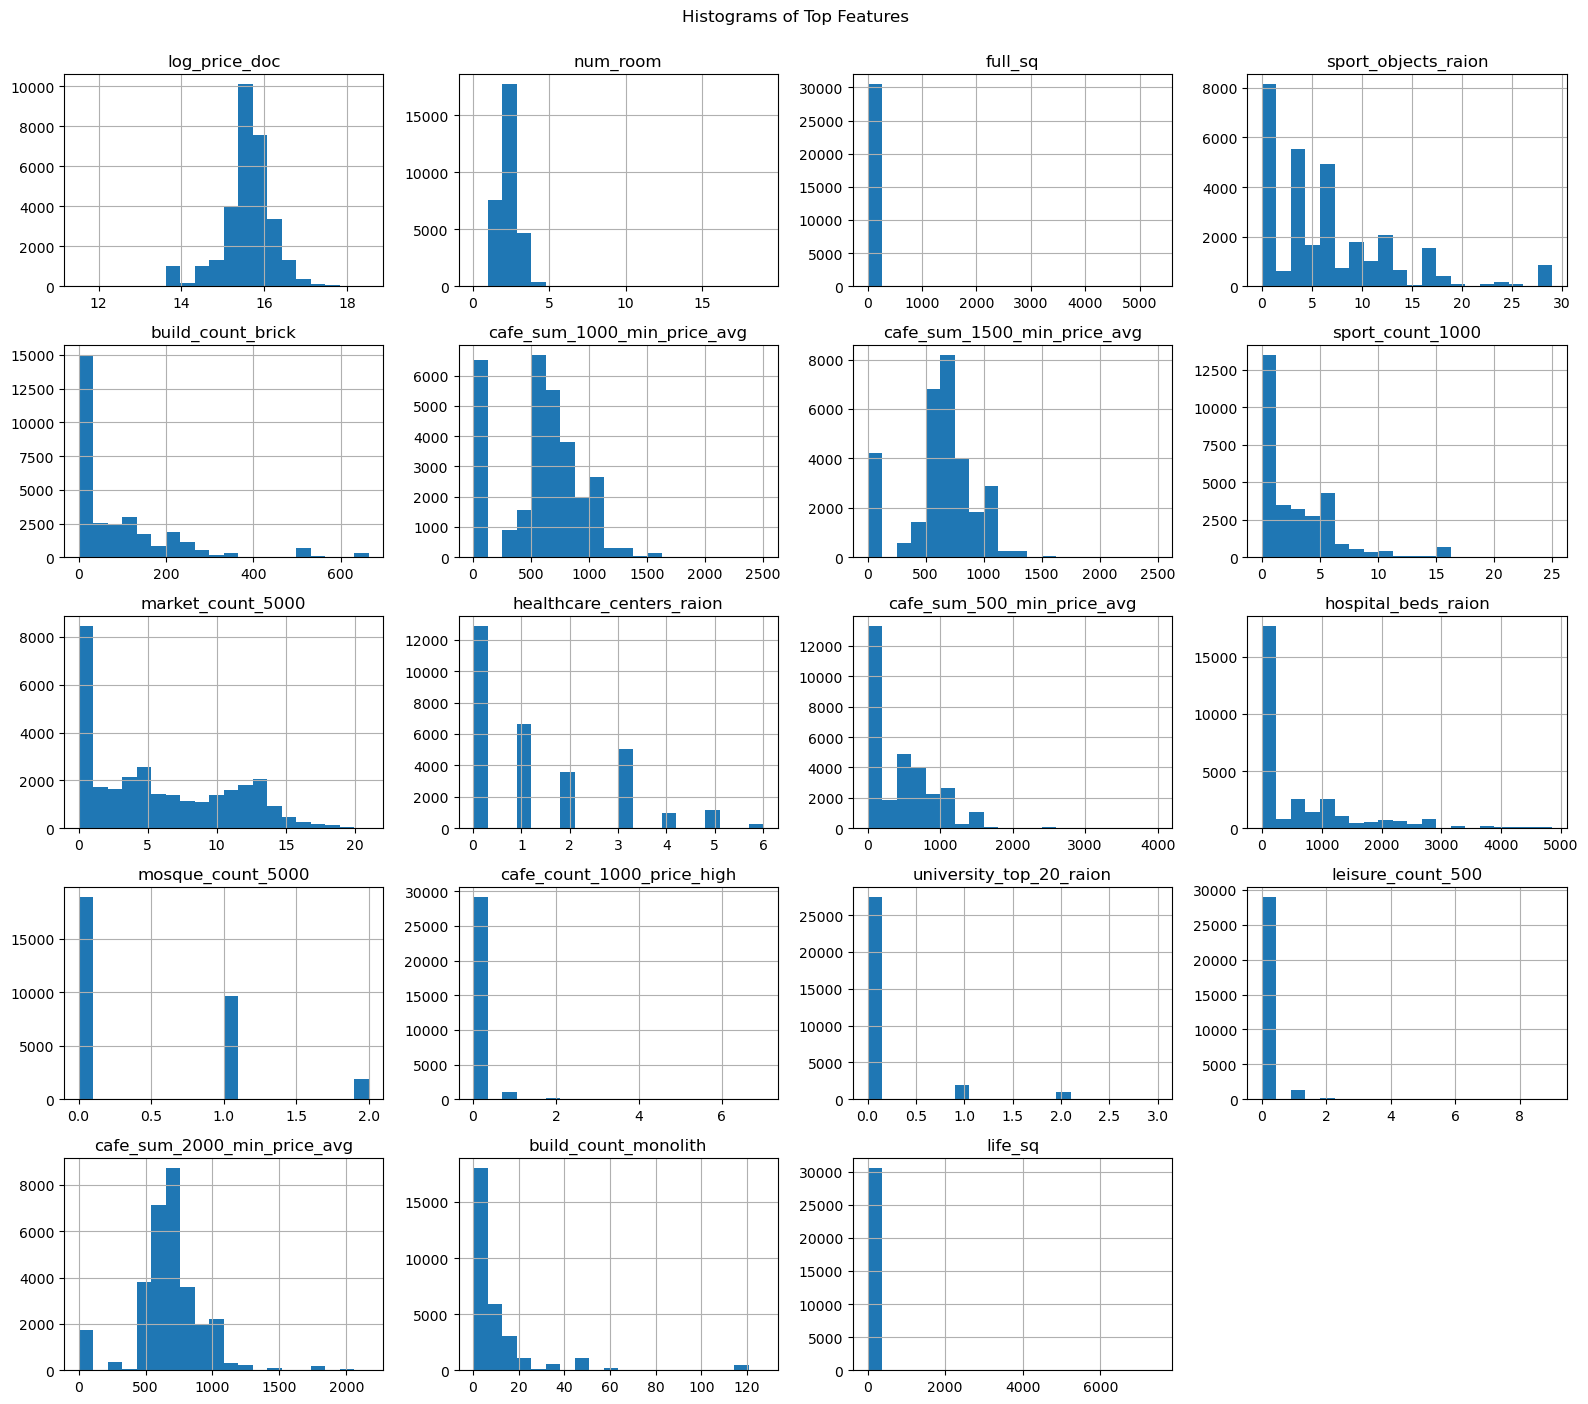

In [42]:
top_20_df.hist(bins=20, figsize=(16, 14), layout=(5, 4))
plt.suptitle('Histograms of Top Features', y=1)
plt.tight_layout()
plt.show()

Let's start examine the columns one by one.
1. **Analysis of `log_price_doc` column**: <br>
The distribution of the column is nearly normal, which is expected since it’s derived from the logarithm of `price_doc`. This is a positive indicator, as a normal distribution is ideal for many statistical analyses. With no significant skewness or outliers, no further transformation is needed.
2. **Analysis of `num_room`(number of living rooms) column**: <br>
The histogram shows an asymmetric distribution with a peak at lower values and a long right tail, indicating that most properties have a small number of rooms, while a few have many. This suggests that small homes dominate the dataset, with some larger, potentially luxury properties. <br>
To begin the in-depth analysis of the **`num_room`** feature, I will first calculate its skewness to assess the distribution and determine if any transformations or adjustments are necessary.

In [43]:
print(f"Skewness of num_room: {skew(reduced_df['num_room'])}")

Skewness of num_room: 1.4154526064859605


Expected positively skewed distribution. It may be beneficial to apply transformations or categorize the feature to improve its distribution for modeling.

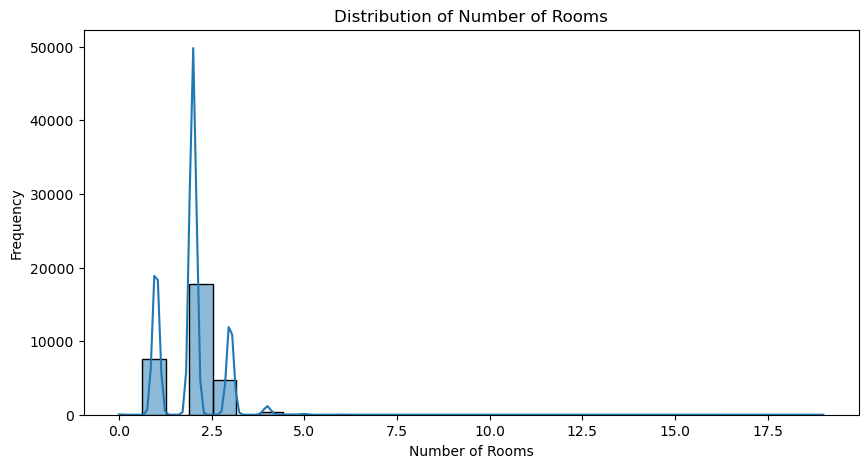

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['num_room'], kde=True, bins=30)
plt.title('Distribution of Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.show()

In [45]:
corr_with_price_doc = reduced_df[['num_room', 'price_doc']].corr()
corr_with_price_doc

,num_room,price_doc
num_room,1.000000,0.397644
price_doc,0.397644,1.000000


I see a moderate positive relationship between the two columns with correlation of 0.40. This indicates that, as the number of rooms increases, the price tends to increase as well, though there are still many other factors influencing the price. I believe it's the right time to apply **`binning`**, as it will simplify the feature and make it more suitable for modeling by reducing the impact of extreme values.

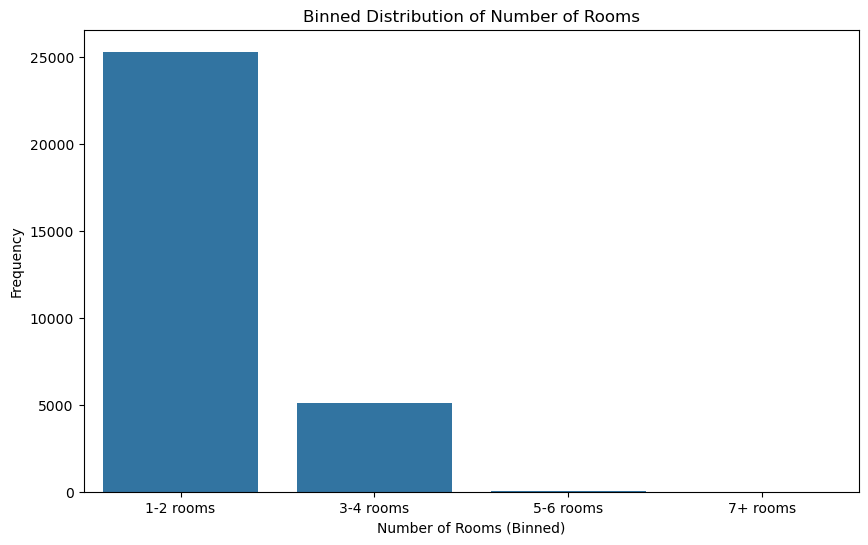

In [46]:
bins = [0, 2, 4, 6, float('inf')]
labels = ['1-2 rooms', '3-4 rooms', '5-6 rooms', '7+ rooms']

reduced_df['num_room_binned'] = pd.cut(reduced_df['num_room'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.countplot(data=reduced_df, x='num_room_binned')
plt.title('Binned Distribution of Number of Rooms')
plt.xlabel('Number of Rooms (Binned)')
plt.ylabel('Frequency')
plt.show()

num_room_binned
1-2 rooms    6.326922e+06
3-4 rooms    1.089624e+07
5-6 rooms    2.196786e+07
7+ rooms     2.833001e+07
Name: price_doc, dtype: float64


C:\Users\Цецо\AppData\Local\Temp\ipykernel_3376\2941353298.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_price_by_bin = reduced_df.groupby('num_room_binned')['price_doc'].mean()


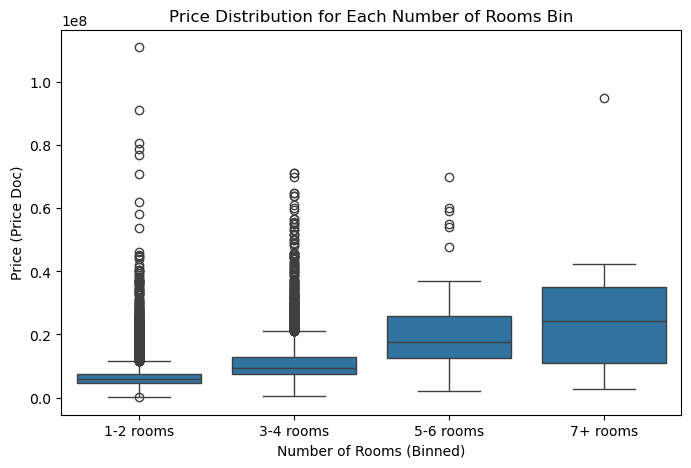

In [47]:
mean_price_by_bin = reduced_df.groupby('num_room_binned')['price_doc'].mean()

print(mean_price_by_bin)

plt.figure(figsize=(8, 5))
sns.boxplot(x='num_room_binned', y='price_doc', data=reduced_df)
plt.title('Price Distribution for Each Number of Rooms Bin')
plt.xlabel('Number of Rooms (Binned)')
plt.ylabel('Price (Price Doc)')
plt.show()

As expected, larger properties with more rooms tend to have higher prices. This confirms that the number of rooms is a good indicator of property price, and the binning has simplified the feature while still retaining useful information.

3. **Analysis of `full_sq`(total area in square meters) column**: <br> 
The histogram shows that the `full_sq` feature has a right-skewed distribution with a long tail. This suggests that most properties have smaller square footage, while a few properties with very large sizes create the skew. To improve the analysis, a logarithmic transformation can be applied to make the distribution more normal and reduce the impact of extreme values.

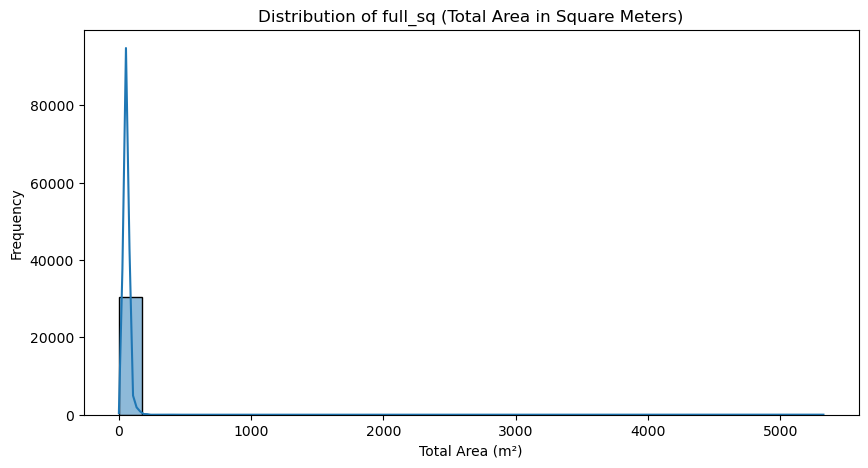

In [48]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['full_sq'], kde=True, bins=30)
plt.title('Distribution of full_sq (Total Area in Square Meters)')
plt.xlabel('Total Area (m²)')
plt.ylabel('Frequency')
plt.show()

In [49]:
print(f"Skewness of full_sq: {skew(reduced_df['full_sq'])}")

Skewness of full_sq: 88.54696347410487


The skewness of full_sq at **88.55 is extremely high**. Let's apply `logarithmic transformation`. It could reduce the impact of extremely large properties on the distribution, helping us achieve a more symmetric, normalized shape. 

In [50]:
reduced_df['log_full_sq'] = np.log1p(reduced_df['full_sq'])

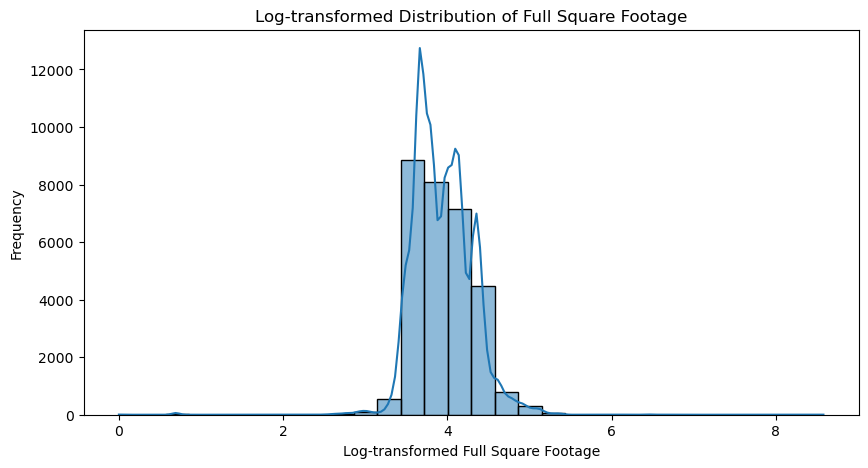

In [51]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['log_full_sq'], kde=True, bins=30)
plt.title('Log-transformed Distribution of Full Square Footage')
plt.xlabel('Log-transformed Full Square Footage')
plt.ylabel('Frequency')
plt.show()

Let's see the correlation before and after the log-transformation.

In [52]:
correlation_full_sq = reduced_df[['full_sq', 'price_doc']].corr()
print(correlation_full_sq)

           full_sq  price_doc
full_sq    1.00000    0.34184
price_doc  0.34184    1.00000


In [53]:
correlation_log_full_sq = reduced_df[['log_full_sq', 'price_doc']].corr()
print(correlation_log_full_sq)

             log_full_sq  price_doc
log_full_sq     1.000000   0.530153
price_doc       0.530153   1.000000


As we can see there is a noticeable improvement over the original correlation. This indicates a stronger positive relationship between the log-transformed square footage and the property price.

5. **Analysis of `build_count_brick` (share of brick buildings) column**: <br>
From the histogram, we can observe that build_count_brick has an asymmetric distribution, with most values concentrated at lower levels and a tail extending to higher values. This suggests that while many areas have a small proportion of brick buildings, a few regions have significantly higher counts. This uneven distribution raises the potential need for transformation or outlier treatment to ensure the column is suitable for modeling.

In [54]:
brick_skew = skew(reduced_df['build_count_brick'])
print(f"Skewness of build_count_brick: {brick_skew}")

Skewness of build_count_brick: 2.1891155820915347


А strong right skew. This suggests that the distribution is heavily concentrated around the lower values, with a long tail towards the higher values, meaning there are a few regions with a significantly higher share of brick buildings.

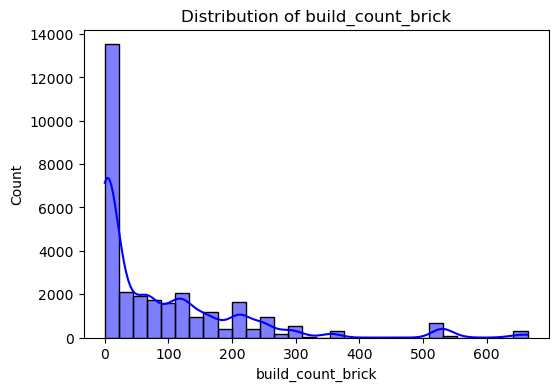

In [55]:
plt.figure(figsize=(6, 4))
sns.histplot(reduced_df['build_count_brick'], bins=30, kde=True, color='blue')
plt.title('Distribution of build_count_brick')
plt.show()

In [56]:
correlation_brick = reduced_df[['build_count_brick', 'price_doc']].corr()
print(correlation_brick)

                   build_count_brick  price_doc
build_count_brick           1.000000   0.211738
price_doc                   0.211738   1.000000


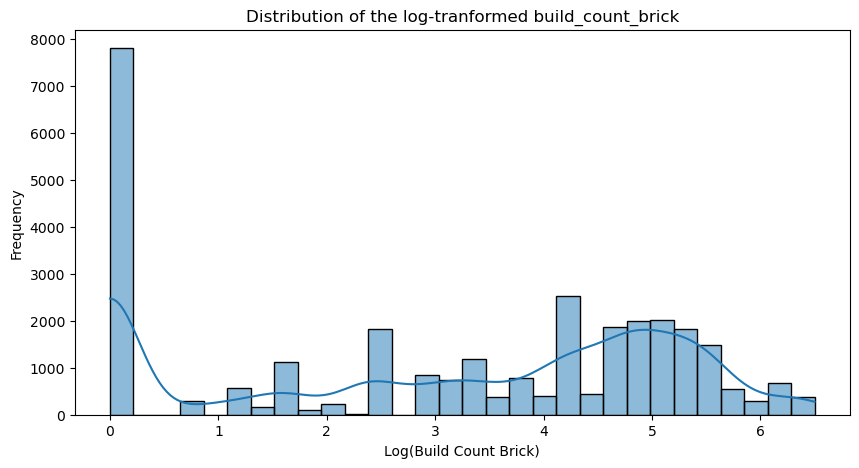

In [57]:
reduced_df['log_build_count_brick'] = np.log1p(reduced_df['build_count_brick'])

plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['log_build_count_brick'], kde=True, bins=30)
plt.title('Distribution of the log-tranformed build_count_brick')
plt.xlabel('Log(Build Count Brick)')
plt.ylabel('Frequency')
plt.show()

In [58]:
correlation_brick = reduced_df[['log_build_count_brick', 'price_doc']].corr()
print(correlation_brick)

                       log_build_count_brick  price_doc
log_build_count_brick               1.000000   0.225907
price_doc                           0.225907   1.000000


In [59]:
Q1_log = reduced_df['log_build_count_brick'].quantile(0.25)
Q3_log = reduced_df['log_build_count_brick'].quantile(0.75)
IQR_log = Q3_log - Q1_log

lower_bound_log = Q1_log - 1.5 * IQR_log
upper_bound_log = Q3_log + 1.5 * IQR_log

outliers_log = reduced_df[(reduced_df['log_build_count_brick'] < lower_bound_log) | 
                          (reduced_df['log_build_count_brick'] > upper_bound_log)]

print(f"Total outliers (after log transformation): {len(outliers_log)}")
print(outliers_log[['log_build_count_brick']].head())

Total outliers (after log transformation): 0
Empty DataFrame
Columns: [log_build_count_brick]
Index: []


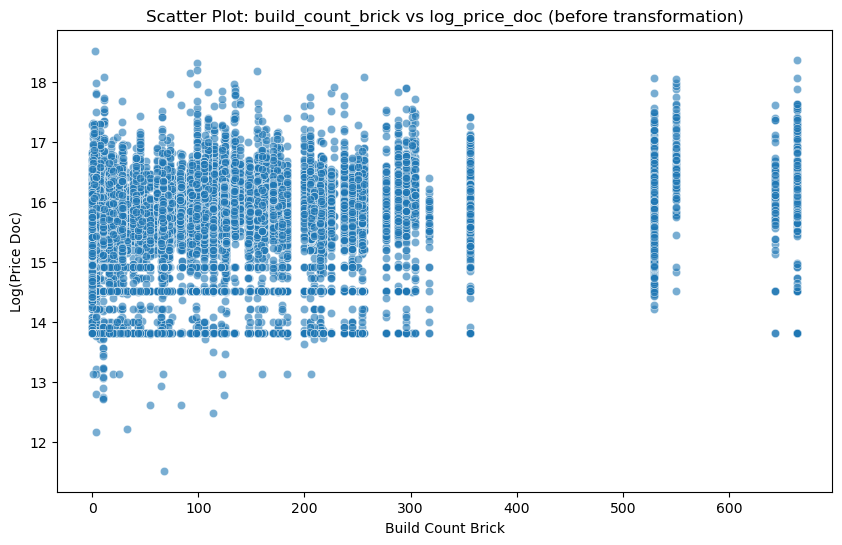

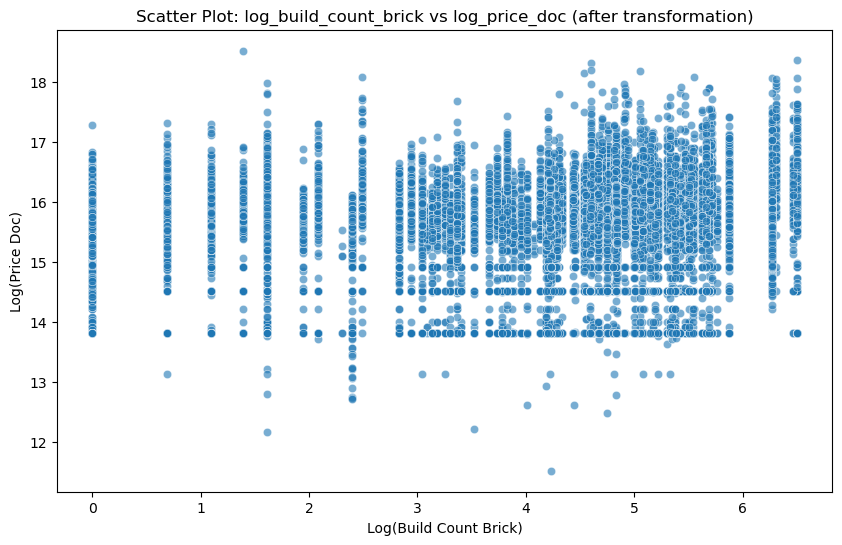

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_df['build_count_brick'], y=reduced_df['log_price_doc'], alpha=0.6)
plt.title('Scatter Plot: build_count_brick vs log_price_doc (before transformation)')
plt.xlabel('Build Count Brick')
plt.ylabel('Log(Price Doc)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_df['log_build_count_brick'], y=reduced_df['log_price_doc'], alpha=0.6)
plt.title('Scatter Plot: log_build_count_brick vs log_price_doc (after transformation)')
plt.xlabel('Log(Build Count Brick)')
plt.ylabel('Log(Price Doc)')
plt.show()

6. **Analysis of `cafe_sum_1000_min_price_avg`, `cafe_sum_1500_min_price_avg`, `cafe_sum_500_min_price_avg` and `cafe_sum_2000_min_price_avg`** columns: <br>
The histograms reveal right-skewed distributions, with most values concentrated at lower price ranges and a small number of areas with significantly higher average minimum prices. This skewness suggests that while the majority of neighborhoods have cafes with relatively low prices, there are exceptions with much higher values.

In [61]:
cafe_columns = [
    'cafe_sum_1000_min_price_avg', 
    'cafe_sum_1500_min_price_avg', 
    'cafe_sum_500_min_price_avg', 
    'cafe_sum_2000_min_price_avg'
]

Analyzing column: cafe_sum_1000_min_price_avg


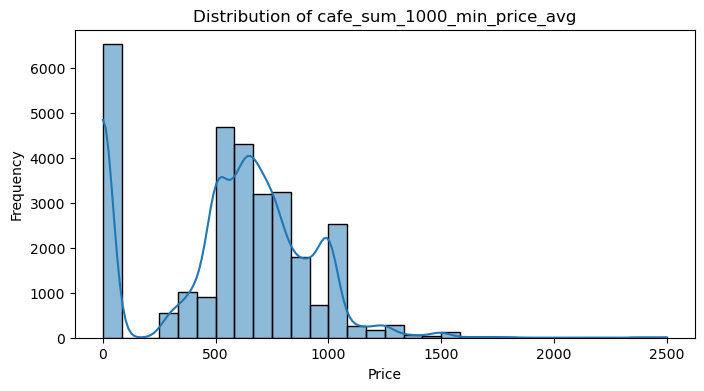

Skewness of cafe_sum_1000_min_price_avg: -0.1468018066883039
Correlation of cafe_sum_1000_min_price_avg with price_doc:
                             cafe_sum_1000_min_price_avg  price_doc
cafe_sum_1000_min_price_avg                     1.000000   0.209861
price_doc                                       0.209861   1.000000

Analyzing column: cafe_sum_1500_min_price_avg


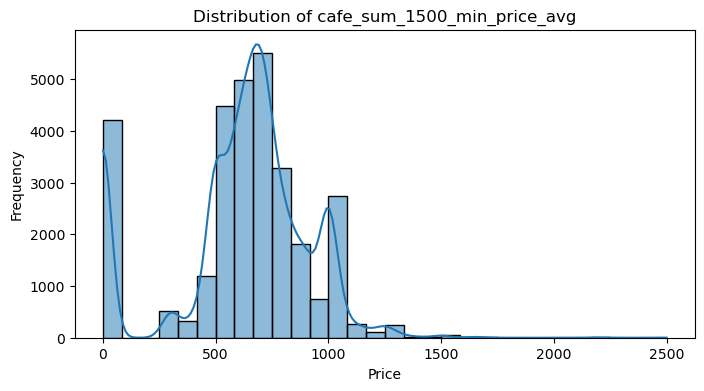

Skewness of cafe_sum_1500_min_price_avg: -0.6107821577437073
Correlation of cafe_sum_1500_min_price_avg with price_doc:
                             cafe_sum_1500_min_price_avg  price_doc
cafe_sum_1500_min_price_avg                     1.000000   0.201923
price_doc                                       0.201923   1.000000

Analyzing column: cafe_sum_500_min_price_avg


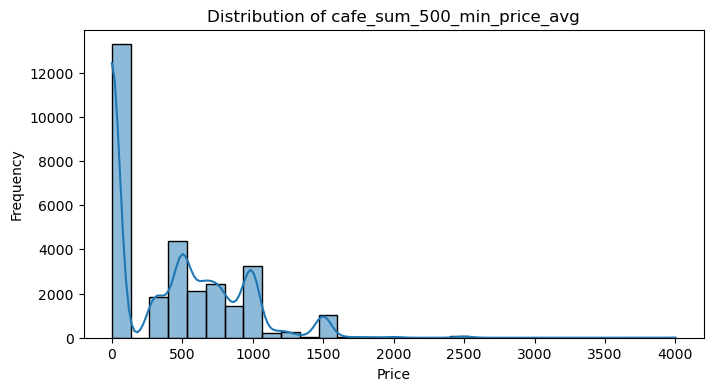

Skewness of cafe_sum_500_min_price_avg: 0.9303980753467015
Correlation of cafe_sum_500_min_price_avg with price_doc:
                            cafe_sum_500_min_price_avg  price_doc
cafe_sum_500_min_price_avg                    1.000000   0.189257
price_doc                                     0.189257   1.000000

Analyzing column: cafe_sum_2000_min_price_avg


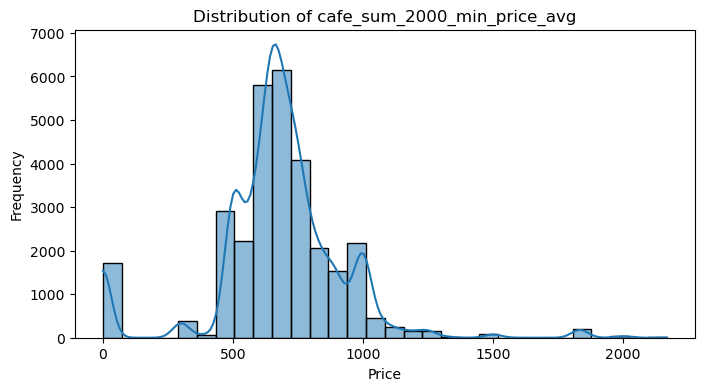

Skewness of cafe_sum_2000_min_price_avg: 0.13211342517872904
Correlation of cafe_sum_2000_min_price_avg with price_doc:
                             cafe_sum_2000_min_price_avg  price_doc
cafe_sum_2000_min_price_avg                      1.00000    0.16014
price_doc                                        0.16014    1.00000



In [62]:
for col in cafe_columns:
    print(f"Analyzing column: {col}")
    
    plt.figure(figsize=(8, 4))
    sns.histplot(reduced_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

    skewness = skew(reduced_df[col].dropna())
    print(f"Skewness of {col}: {skewness}")

    correlation = reduced_df[[col, 'price_doc']].corr()
    print(f"Correlation of {col} with price_doc:\n{correlation}\n")
    

Looking at the analysis I did for the four columns I can draw the following conclusions:
1. The skewness analysis of the cafe price columns reveals that cafe_sum_1000_min_price_avg has minimal skewness (-0.147), indicating a near-symmetric distribution, while cafe_sum_1500_min_price_avg shows a slight negative skew (-0.611), suggesting more areas with higher prices. In contrast, cafe_sum_500_min_price_avg exhibits a positive skew (0.930), pointing to a tail towards higher values, and cafe_sum_2000_min_price_avg is almost symmetric (0.132).
2. All columns show weak positive correlations with price_doc, with values ranging between 0.16 and 0.21. The highest correlation is observed for cafe_sum_1000_min_price_avg (0.21), while the lowest is for cafe_sum_2000_min_price_avg (0.16).

To simplify the analysis and reveal potential patterns, the next step will involve binning each cafe price column into categories such as "low", "medium", and "high" based on percentile ranges. This will reduce the impact of extreme values and make it easier to assess relationships with property prices. After binning, I will evaluate the average property price within each category to explore any clear trends.

In [71]:
for column in cafe_columns:
    bins = [reduced_df[column].min() - 1, 
            reduced_df[column].quantile(0.33), 
            reduced_df[column].quantile(0.66), 
            reduced_df[column].max()]
    
labels = ['Low', 'Medium', 'High']

for column in ['cafe_sum_1000_min_price_avg', 
               'cafe_sum_1500_min_price_avg', 
               'cafe_sum_500_min_price_avg', 
               'cafe_sum_2000_min_price_avg']:
    reduced_df[f'{column}_binned'] = pd.cut(reduced_df[column], bins=bins, labels=labels)

reduced_df[[f'{col}_binned' for col in ['cafe_sum_1000_min_price_avg', 
                                        'cafe_sum_1500_min_price_avg', 
                                        'cafe_sum_500_min_price_avg', 
                                        'cafe_sum_2000_min_price_avg']]].head()

,cafe_sum_1000_min_price_avg_binned,cafe_sum_1500_min_price_avg_binned,cafe_sum_500_min_price_avg_binned,cafe_sum_2000_min_price_avg_binned
0,Low,Low,Low,Low
1,Low,Medium,High,Medium
2,Medium,Low,Medium,Low
3,Medium,Medium,High,Medium
4,High,High,Medium,High


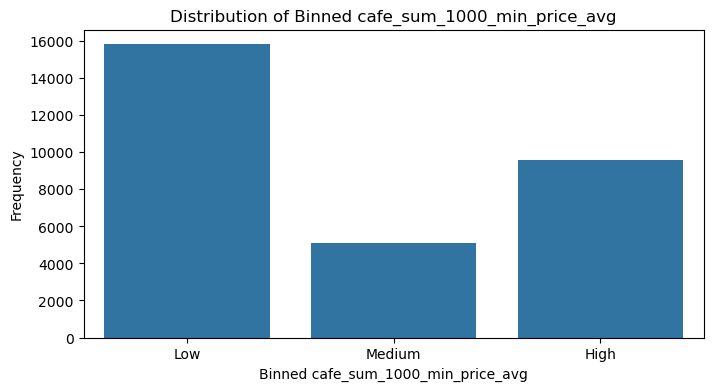

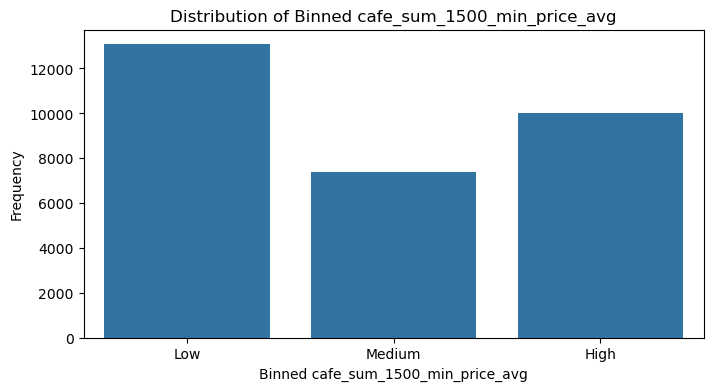

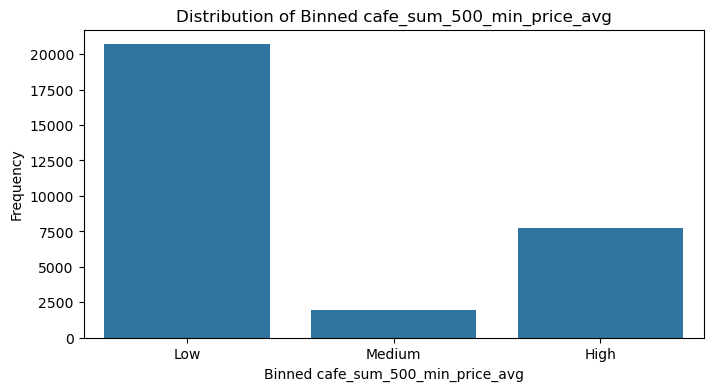

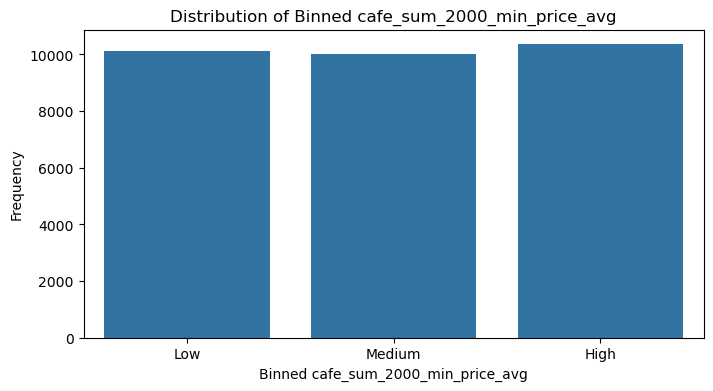

In [79]:
for column in cafe_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=reduced_df[f'{column}_binned'])
    plt.title(f'Distribution of Binned {column}')
    plt.xlabel(f'Binned {column}')
    plt.ylabel('Frequency')
    plt.show()

Next, I will calculate the average property price for each of the bins in order to understand the relationship between the categorized cafe prices and property prices.

In [80]:
for column in cafe_columns:
    correlation_binned = reduced_df[[f'{column}_binned', 'price_doc']].groupby(f'{column}_binned')['price_doc'].mean()
    print(correlation_binned)

cafe_sum_1000_min_price_avg_binned
Low       6.203155e+06
Medium    7.880674e+06
High      8.236422e+06
Name: price_doc, dtype: float64
cafe_sum_1500_min_price_avg_binned
Low       6.115507e+06
Medium    7.465713e+06
High      8.185386e+06
Name: price_doc, dtype: float64
cafe_sum_500_min_price_avg_binned
Low       6.580039e+06
Medium    8.264101e+06
High      8.278635e+06
Name: price_doc, dtype: float64
cafe_sum_2000_min_price_avg_binned
Low       6.007241e+06
Medium    7.215635e+06
High      8.122892e+06
Name: price_doc, dtype: float64


C:\Users\Цецо\AppData\Local\Temp\ipykernel_3376\1757777591.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlation_binned = reduced_df[[f'{column}_binned', 'price_doc']].groupby(f'{column}_binned')['price_doc'].mean()
C:\Users\Цецо\AppData\Local\Temp\ipykernel_3376\1757777591.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlation_binned = reduced_df[[f'{column}_binned', 'price_doc']].groupby(f'{column}_binned')['price_doc'].mean()
C:\Users\Цецо\AppData\Local\Temp\ipykernel_3376\1757777591.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future 

The results show how property prices vary across the cafe price bins in the surrounding areas. The trend suggests that areas with higher average cafe prices are generally associated with higher property prices.

7. **Analysis of `sport_count_1000`, `market_count_5000`, `healthcare_centers_raion` and `hospital_beds_raion` columns**: <br>
These columns represent the number of sports facilities, markets, healthcare centers, and hospital beds within the surrounding area of a property. The distributions show right-skewness, indicating that most properties are in areas with fewer amenities, while a few have access to more. I will analyze the correlation between these features and property prices to understand their impact and decide if any transformations or binning are needed for modeling.

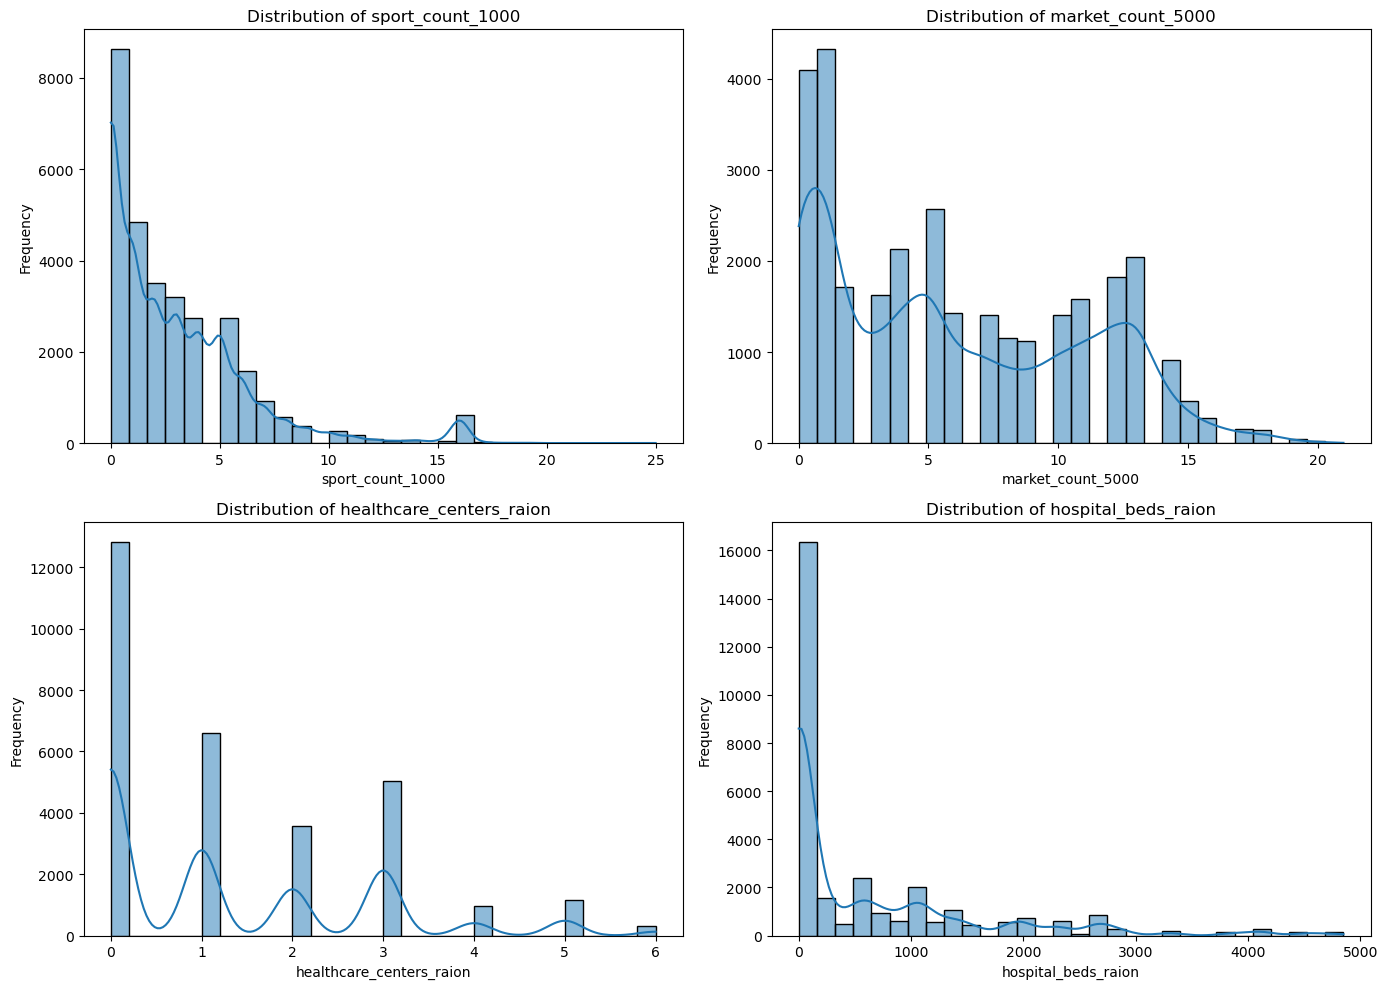

In [83]:
columns_to_plot = ['sport_count_1000', 'market_count_5000', 'healthcare_centers_raion', 'hospital_beds_raion']
plt.figure(figsize=(14, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(reduced_df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

I’ll calculate the skewness for each of these columns to quantify the degree of asymmetry in the distributions which will help me decide whether any transformations (e.g., log-transformation) are necessary.

In [84]:
for column in columns_to_plot:
    print(f"Skewness of {column}: {skew(reduced_df[column])}")

Skewness of sport_count_1000: 1.859730487357919
Skewness of market_count_5000: 0.43529295309826954
Skewness of healthcare_centers_raion: 1.0003457728613319
Skewness of hospital_beds_raion: 1.9590434250027196


The skewness values for the columns indicate that sport_count_1000 (1.86) and hospital_beds_raion (1.96) have strong right skew, suggesting most areas have fewer facilities with some exceptions. healthcare_centers_raion (1.00) also shows a right skew, while market_count_5000 (0.44) has a mild skew, indicating a slightly higher concentration of areas with fewer markets.

It might be useful to perform `log-transformation` (for three of the columns) to make the distribution more symmetric, reducing the influence of extreme values on the model.

In [86]:
for column in columns_to_plot:
    skew_value = skew(reduced_df[column])
    if abs(skew_value) > 1:  
        reduced_df[f'log_{column}'] = reduced_df[column].apply(lambda x: np.log(x + 1))
        print(f"Log-transformation applied to {column}")

Log-transformation applied to sport_count_1000
Log-transformation applied to healthcare_centers_raion
Log-transformation applied to hospital_beds_raion


As next step, It's important to check how each of these variables correlates with the target variable, price_doc.

In [87]:
for column in columns_to_plot:
    correlation = reduced_df[[column, 'price_doc']].corr()
    print(f"Correlation between {column} and price_doc:\n{correlation}\n")

Correlation between sport_count_1000 and price_doc:
                  sport_count_1000  price_doc
sport_count_1000          1.000000   0.197994
price_doc                 0.197994   1.000000

Correlation between market_count_5000 and price_doc:
                   market_count_5000  price_doc
market_count_5000           1.000000   0.194021
price_doc                   0.194021   1.000000

Correlation between healthcare_centers_raion and price_doc:
                          healthcare_centers_raion  price_doc
healthcare_centers_raion                  1.000000   0.190006
price_doc                                 0.190006   1.000000

Correlation between hospital_beds_raion and price_doc:
                     hospital_beds_raion  price_doc
hospital_beds_raion             1.000000   0.177578
price_doc                       0.177578   1.000000



These correlations suggest that while the presence of sports, markets, and healthcare facilities might have some influence on property prices, the relationship is not particularly strong.

8. **Analysis of `mosque_count_5000` and `university_top_20_raion`**: <br>
The distributions of both columns are heavily skewed toward lower values, indicating that most regions have few or no mosques or top-20 universities within a 5000-meter radius. This suggests that these institutions are not widespread across the dataset, with many areas having either none or only a few such establishments. Although mosques and universities are scarce in most regions, it’s worth investigating whether areas with more of these institutions have higher property prices. Even small numbers of such institutions could correlate with higher real estate values, as proximity to universities may drive rental demand or mosques may attract specific demographics. This could reveal how geographic factors like religious and educational institutions impact property prices.

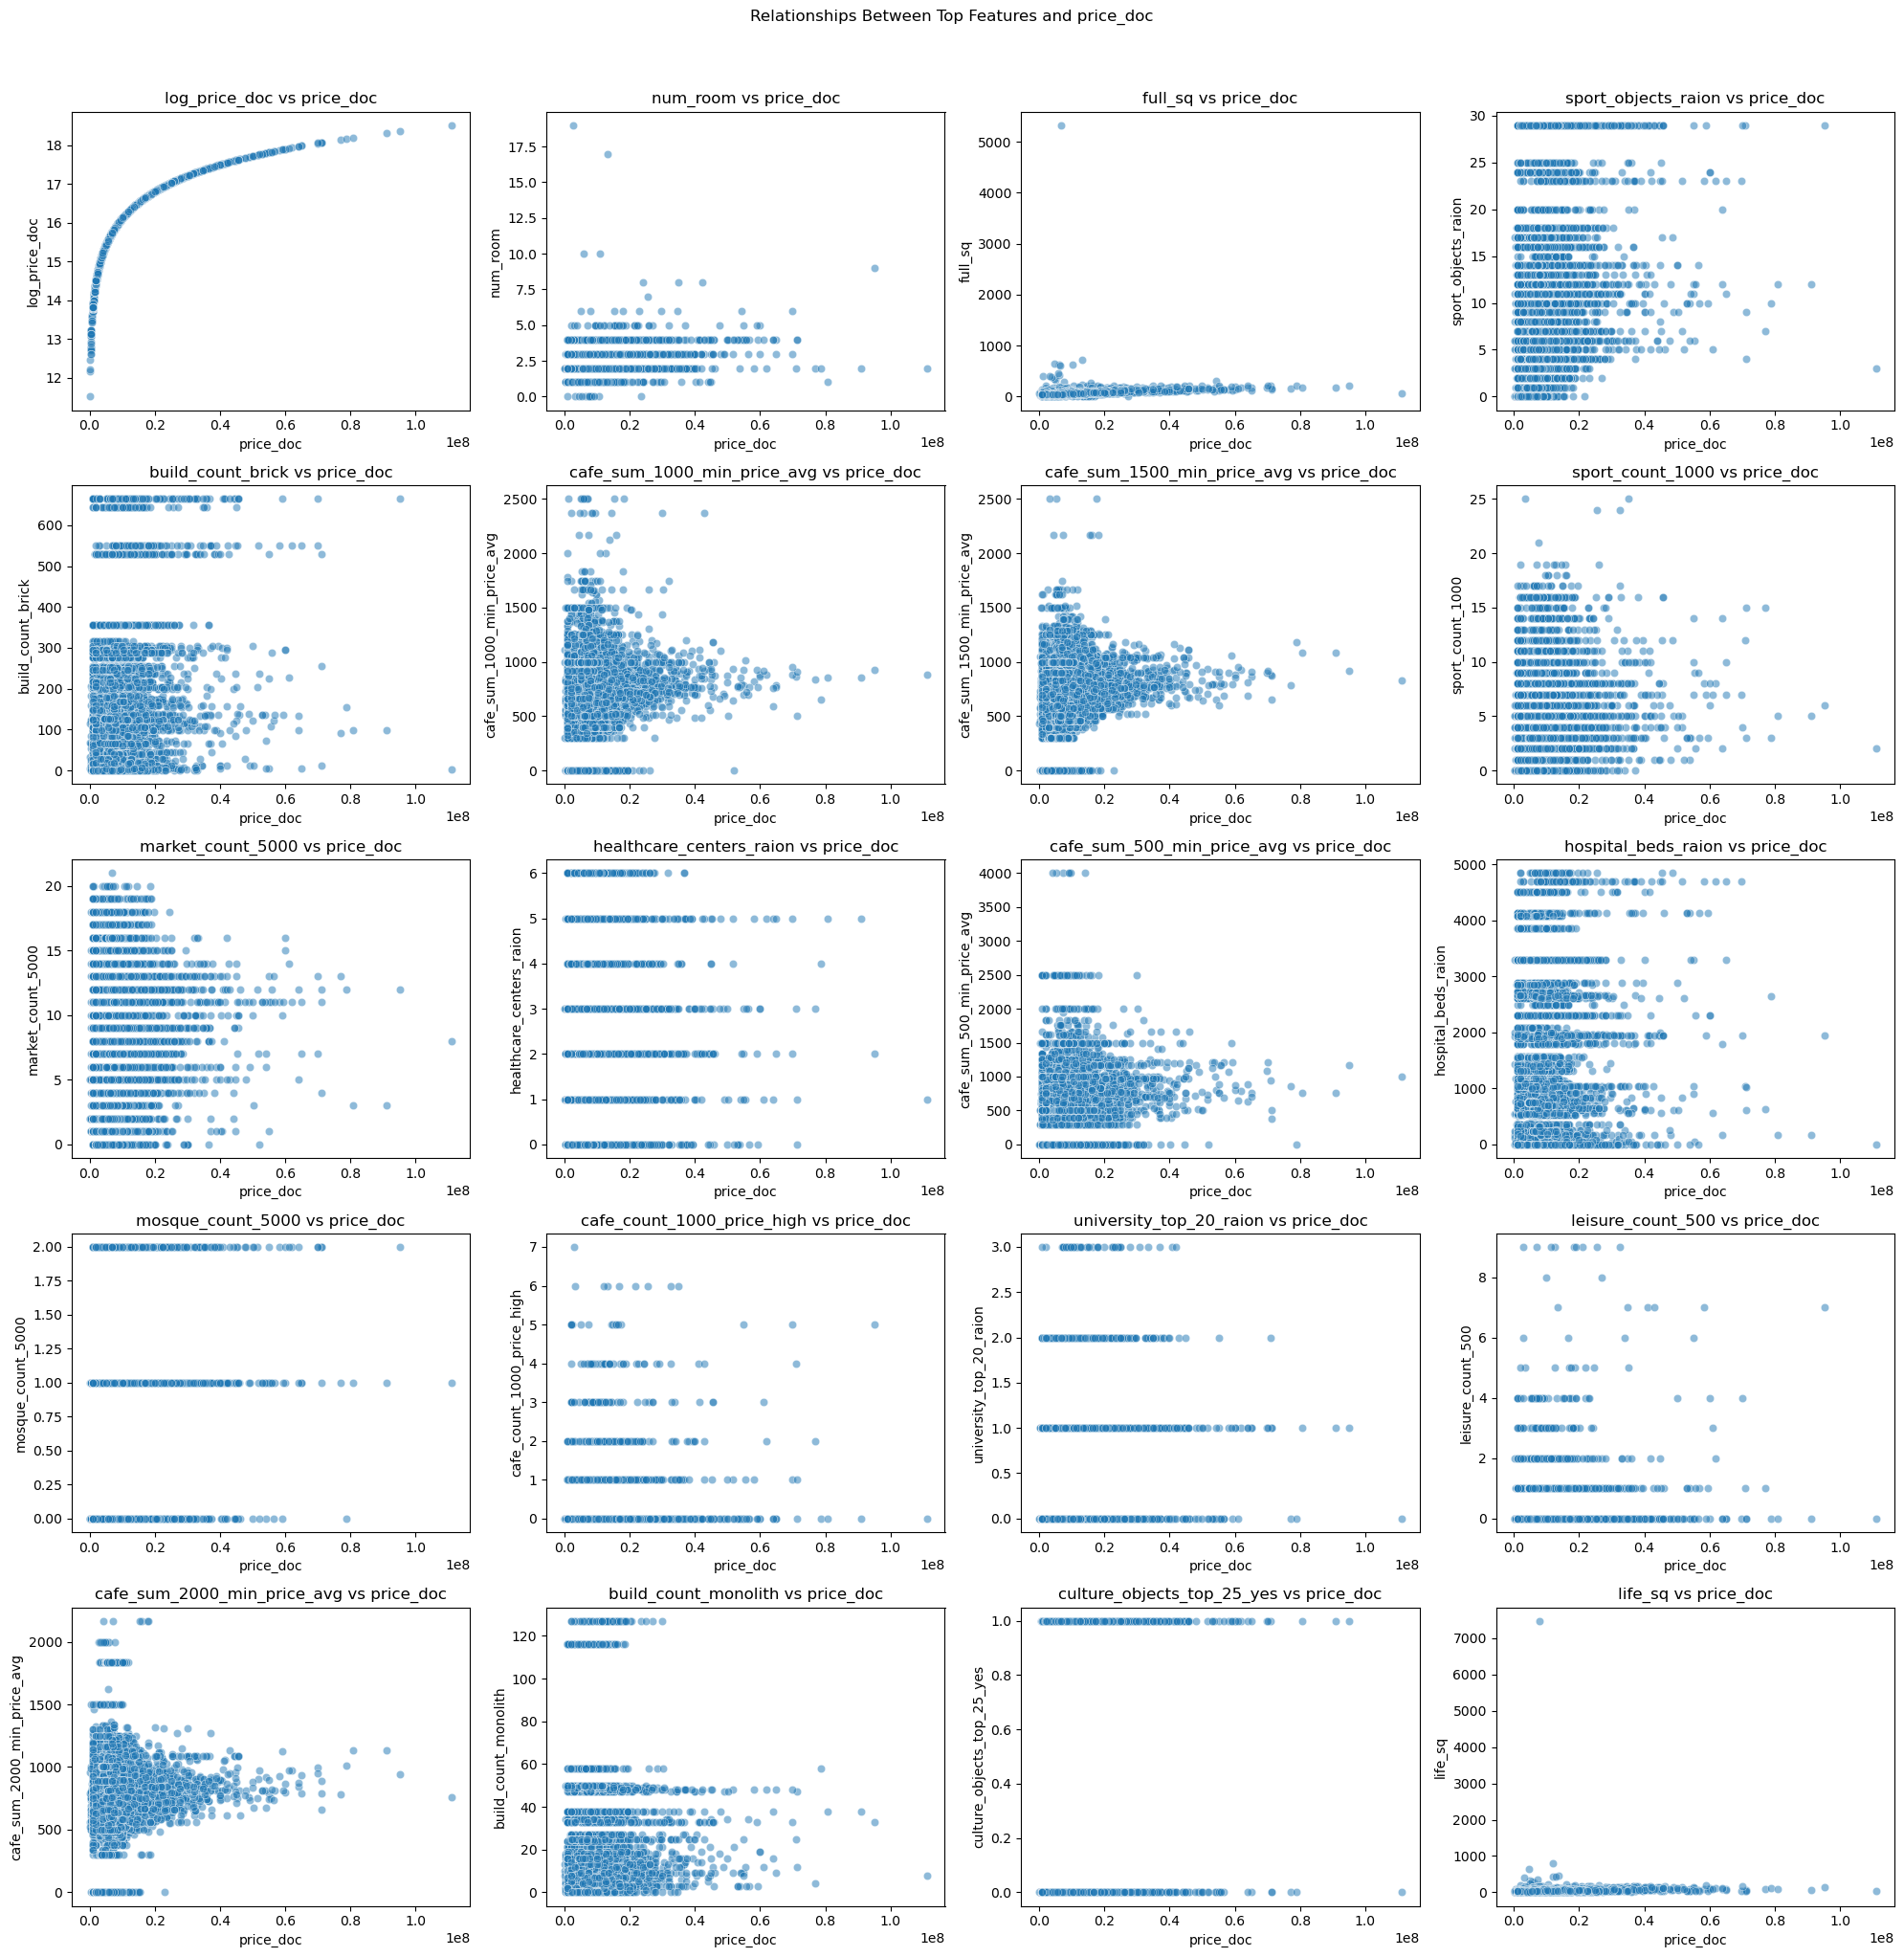

In [60]:
plt.figure(figsize=(20, 20))

for i, feature in enumerate(top_20_df.columns):
    plt.subplot(5, 4, i + 1)
    sns.scatterplot(data=encoded_df, x='price_doc', y=feature, alpha=0.5)
    plt.title(f'{feature} vs price_doc')
    
plt.suptitle('Relationships Between Top Features and price_doc', y=1.02)
plt.tight_layout()
plt.show()

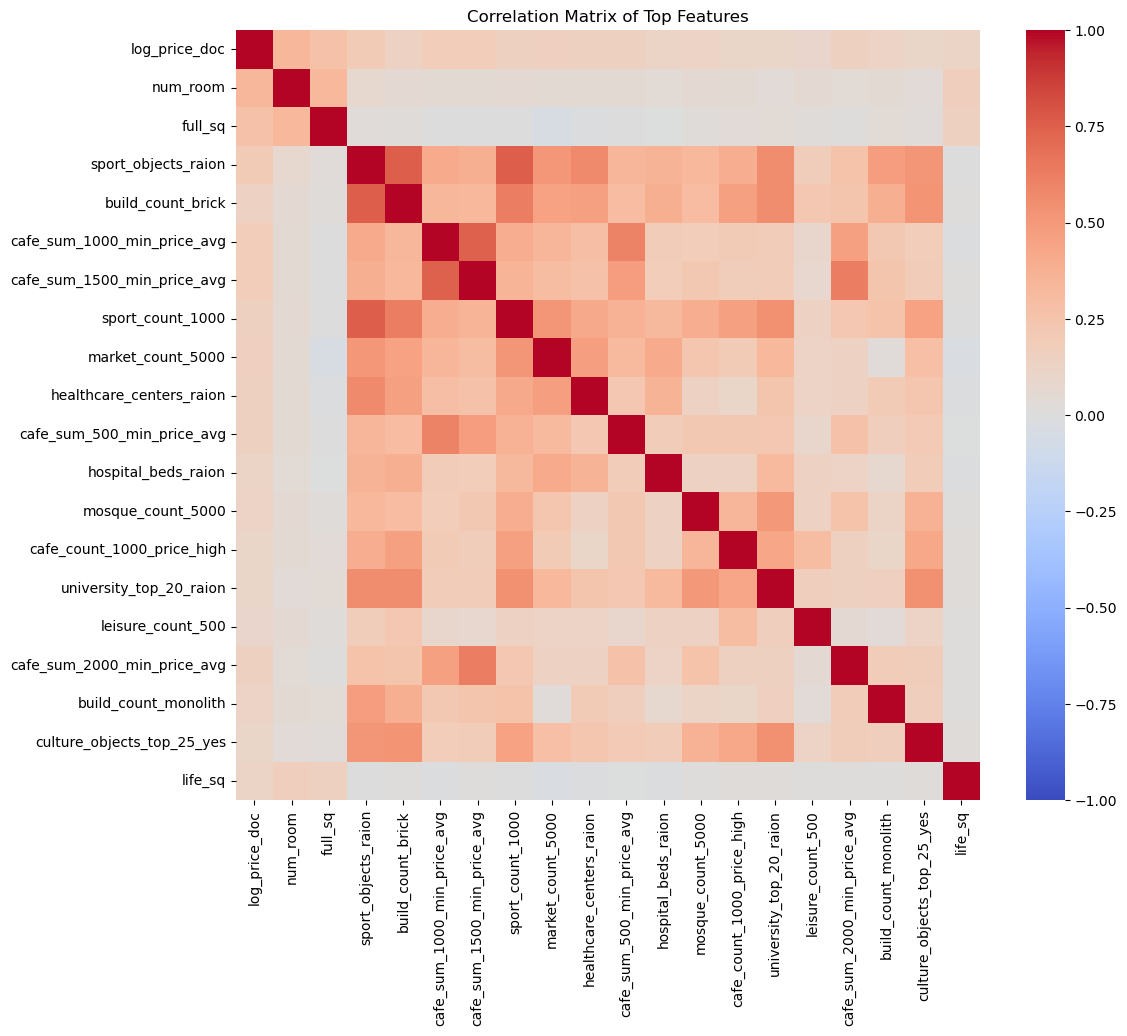

In [64]:
plt.figure(figsize=(12, 10))
corr_matrix = encoded_df[top_20_df.columns].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Top Features')
plt.show()

## Categorical Feature Analysis

In [40]:
for column in reduced_df.select_dtypes(include='object').columns:
    reduced_df[column] = reduced_df[column].astype('category')

In [41]:
reduced_df.select_dtypes(include='category').nunique()

product_type                   2
sub_area                     146
culture_objects_top_25         2
thermal_power_plant_raion      2
incineration_raion             2
oil_chemistry_raion            2
radiation_raion                2
railroad_terminal_raion        2
big_market_raion               2
nuclear_reactor_raion          2
detention_facility_raion       2
water_1line                    2
big_road1_1line                2
railroad_1line                 2
ecology                        5
modern_education_share         4
dtype: int64

After reviewing the categorical columns in the reduced dataset, I found an error in the `modern_education_share` column. Upon inspection using:

In [42]:
reduced_df.select_dtypes(include='category').modern_education_share.unique()

[0, '90,92', '93,08', '95,4918']
Categories (4, object): [0, '90,92', '93,08', '95,4918']

I noticed that `modern_education_share` contained values like 0, '90,92', '93,08', and '95,4918'. These entries are problematic because some values use commas (,) as decimal separators, causing parsing issues when attempting to work with this column numerically.

In [43]:
reduced_df['modern_education_share'] = reduced_df['modern_education_share'].astype(str).replace({',': '.'}, regex=True)

To resolve this, I first converted all values to strings and then replaced commas with dots, enabling proper float conversion:

In [44]:
reduced_df['modern_education_share'] = reduced_df['modern_education_share'].astype(float)

This approach ensures consistent formatting by first treating all entries as strings, then converting commas to dots, and finally casting the column to float. Now, `modern_education_share` is correctly formatted as a numeric column, ready for further analysis or modeling.

In [45]:
reduced_df.select_dtypes(include='category').nunique()

product_type                   2
sub_area                     146
culture_objects_top_25         2
thermal_power_plant_raion      2
incineration_raion             2
oil_chemistry_raion            2
radiation_raion                2
railroad_terminal_raion        2
big_market_raion               2
nuclear_reactor_raion          2
detention_facility_raion       2
water_1line                    2
big_road1_1line                2
railroad_1line                 2
ecology                        5
dtype: int64

I identified that certain features, such as `product_type`, `thermal_power_plant_raion` and `water_1line` have only **2 unique values**, making them binary and suitable for **0/1 (binary) encoding**. The `sub_area` feature has high cardinality with **146 unique values**, indicating it may need advanced encoding techniques. Features like `ecology` **(5 categories)** and `modern_education_share` **(4 categories)** can likely be handled with **one-hot encoding**. I will now apply the appropriate encoding strategies to transform these features for further analysis and modeling.

In [46]:
categorical_columns = reduced_df.select_dtypes(include='category')

### Binary Features Encoding

I will start with encoding the binary features.

In [47]:
binary_features = [col for col in categorical_columns if categorical_columns[col].nunique() == 2]

In [48]:
binary_features

['product_type',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line']

In [49]:
reduced_df[binary_features] = reduced_df[binary_features].apply(lambda x: x.cat.codes)

In [50]:
reduced_df.oil_chemistry_raion.unique()

array([0, 1], dtype=int8)

As we can see, the binary features like `oil_chemistry_raion` already contain only 0 or 1 values. This means that these features are already in a numerical format suitable for modeling

### Multiclass Features Encoding

Now, I will handle the multiclass features.

In [51]:
multiclass_features = [col for col in categorical_columns if 2 < categorical_columns[col].nunique() < 10]

In [52]:
multiclass_features

['ecology']

In my case the only column in this group is `ecology`.

In [53]:
reduced_df.ecology

0                good
1           excellent
2                poor
3                good
4           excellent
             ...     
30466            good
30467            poor
30468         no data
30469    satisfactory
30470            poor
Name: ecology, Length: 30471, dtype: category
Categories (5, object): ['excellent', 'good', 'no data', 'poor', 'satisfactory']

I will apply **One-Hot Encoding** to the `ecology` feature, which will create separate binary columns for each of the **5 categories** in the column. This will transform the feature into a format that can be used in machine learning models.

In [54]:
reduced_df = pd.get_dummies(reduced_df, columns=['ecology'], drop_first=False)

In [55]:
reduced_df[reduced_df.columns[-5:]]

,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
0,False,True,False,False,False
1,True,False,False,False,False
2,False,False,False,True,False
3,False,True,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
30466,False,True,False,False,False
30467,False,False,False,True,False
30468,False,False,True,False,False
30469,False,False,False,False,True


### Encoding Categorical Features with High Cardinality

To determine the best encoding strategy for a **high cardinality feature**, I will first apply Label Encoding, which converts the categorical values into numerical labels. The goal is to evaluate the correlation between the encoded feature and the target variable (price_doc). By checking this correlation, I can assess whether Label Encoding captures meaningful information. This step will help decide whether Target Encoding (based on the mean of the target) or Frequency Encoding (based on category frequencies) is more suitable for this feature.

In [56]:
high_cardinality_features = [col for col in categorical_columns if 10 < categorical_columns[col].nunique()]

In [57]:
high_cardinality_features

['sub_area']

In [58]:
reduced_df.sub_area

0                    Bibirevo
1           Nagatinskij Zaton
2              Tekstil'shhiki
3                      Mitino
4                   Basmannoe
                 ...         
30466                Otradnoe
30467                Tverskoe
30468    Poselenie Vnukovskoe
30469            Obruchevskoe
30470             Novogireevo
Name: sub_area, Length: 30471, dtype: category
Categories (146, object): ['Ajeroport', 'Akademicheskoe', 'Alekseevskoe', 'Altuf'evskoe', ..., 'Zamoskvorech'e', 'Zapadnoe Degunino', 'Zjablikovo', 'Zjuzino']

In [59]:
label_encoder = LabelEncoder()

In [60]:
reduced_df['encoded_sub_area'] = label_encoder.fit_transform(reduced_df['sub_area'])

In [61]:
reduced_df['encoded_sub_area'].unique()

array([  9,  70, 129,  65,   6,  73, 122,  44,  50,  45, 143, 107,  53,
        60,  52,  71,  27, 136,  40, 118,  17,  25,  82,  74,  12,  36,
       126,  32,  67, 125,  56,  15, 135,  20, 106,  43,  13, 140, 141,
        22,  75,  38, 121,  51,  34, 117, 111,  80,  78, 128,  21,  79,
       130,   5,  85,  77,  24, 133, 115,  29, 124,  23, 131,  55,  83,
        48,  37,  19, 110, 120,  33,  28,  76,  69,  10, 116, 123, 139,
       108, 112,   0, 137,   8,  49,  41,  84,   1,  30, 119,  42,  31,
        61,  18, 113,  11,  72,  16, 127,   2,  47,  46, 145,  81, 134,
        58,  14,  62,  64,  39,  57,  35,  68,  54,  59,  26, 142,   3,
       109, 144,  63, 114,   7,   4, 102,  94,  97,  86, 105,  95, 132,
       101,  87, 103,  92, 100,  98,  90, 138,  91,  96, 104,  89,  99,
        88,  66,  93])

In [62]:
correlation = reduced_df['encoded_sub_area'].corr(reduced_df['price_doc'])
print(f"Correlation between encoded sub_area and price_doc: {correlation}")

Correlation between encoded sub_area and price_doc: -0.08805495891725802


After calculating the correlation between the encoded `sub_area` and the `target variable (price_doc)`, which turned out to be **-0.088**, I concluded that Label Encoding does not provide a strong relationship with the target. Based on this, I decided that **Frequency Encoding** would be a better option for this feature. It will assign each category a value based on its frequency, which could potentially capture more meaningful patterns related to the target variable.

In [63]:
reduced_df = reduced_df.drop(columns=['encoded_sub_area'])

In [64]:
frequency_encoding = reduced_df['sub_area'].value_counts(normalize=True) 

In [65]:
frequency_encoding

sub_area
Poselenie Sosenskoe               0.058285
Nekrasovka                        0.052870
Poselenie Vnukovskoe              0.045026
Poselenie Moskovskij              0.030357
Poselenie Voskresenskoe           0.023399
                                    ...   
Molzhaninovskoe                   0.000098
Poselenie Kievskij                0.000066
Poselenie Shhapovskoe             0.000066
Poselenie Klenovskoe              0.000033
Poselenie Mihajlovo-Jarcevskoe    0.000033
Name: proportion, Length: 146, dtype: float64

In [66]:
reduced_df['frequency_encoded_sub_area'] = reduced_df['sub_area'].map(frequency_encoding)

In [1]:
print(reduced_df[['sub_area', 'frequency_encoded_sub_area']].head())

SyntaxError: incomplete input (2874395367.py, line 1)

In [77]:
correlation = reduced_df['frequency_encoded_sub_area'].corr(reduced_df['price_doc'])
print(f"Correlation between frequency encoded sub_area and price_doc: {correlation}")

Correlation between frequency encoded sub_area and price_doc: -0.18125553526214627


In [101]:
sub_area_to_district = {
    "Bibirevo": "Northern Administrative Okrug",
    "Nagatinskij Zaton": "Southern Administrative Okrug",
    "Tekstil'shhiki": "Southeast Administrative Okrug",
    "Mitino": "Western Administrative Okrug",
    "Basmannoe": "Central Administrative Okrug",
    "Nizhegorodskoe": "Eastern Administrative Okrug",
    "Sokol'niki": "Eastern Administrative Okrug",
    "Koptevo": "Northern Administrative Okrug",
    "Kuncevo": "Western Administrative Okrug",
    "Kosino-Uhtomskoe": "Southeast Administrative Okrug",
    "Zapadnoe Degunino": "Northern Administrative Okrug",
    "Presnenskoe": "Central Administrative Okrug",
    "Lefortovo": "Southeast Administrative Okrug",
    "Mar'ino": "Southern Administrative Okrug",
    "Kuz'minki": "Southeast Administrative Okrug",
    "Nagornoe": "Southern Administrative Okrug",
    "Gol'janovo": "Eastern Administrative Okrug",
    "Vnukovo": "Western Administrative Okrug",
    "Juzhnoe Tushino": "Western Administrative Okrug",
    "Severnoe Tushino": "Northern Administrative Okrug",
    "Chertanovo Central'noe": "Southern Administrative Okrug",
    "Fili Davydkovo": "Western Administrative Okrug",
    "Otradnoe": "Northwestern Administrative Okrug",
    "Novo-Peredelkino": "Western Administrative Okrug",
    "Bogorodskoe": "Eastern Administrative Okrug",
    "Jaroslavskoe": "Northern Administrative Okrug",
    "Strogino": "Western Administrative Okrug",
    "Hovrino": "Northern Administrative Okrug",
    "Moskvorech'e-Saburovo": "Southern Administrative Okrug",
    "Staroe Krjukovo": "Northwestern Administrative Okrug",
    "Ljublino": "Southern Administrative Okrug",
    "Caricyno": "Southern Administrative Okrug",
    "Veshnjaki": "Eastern Administrative Okrug",
    "Danilovskoe": "Southern Administrative Okrug",
    "Preobrazhenskoe": "Eastern Administrative Okrug",
    "Kon'kovo": "Southern Administrative Okrug",
    "Brateevo": "Southern Administrative Okrug",
    "Vostochnoe Izmajlovo": "Eastern Administrative Okrug",
    "Vyhino-Zhulebino": "Southeast Administrative Okrug",
    "Donskoe": "Southern Administrative Okrug",
    "Novogireevo": "Eastern Administrative Okrug",
    "Juzhnoe Butovo": "Southern Administrative Okrug",
    "Sokol": "Northern Administrative Okrug",
    "Kurkino": "Northwestern Administrative Okrug",
    "Izmajlovo": "Eastern Administrative Okrug",
    "Severnoe Medvedkovo": "Northern Administrative Okrug",
    "Rostokino": "Eastern Administrative Okrug",
    "Orehovo-Borisovo Severnoe": "Southern Administrative Okrug",
    "Ochakovo-Matveevskoe": "Southwestern Administrative Okrug",
    "Taganskoe": "Central Administrative Okrug",
    "Dmitrovskoe": "Northern Administrative Okrug",
    "Orehovo-Borisovo Juzhnoe": "Southern Administrative Okrug",
    "Teplyj Stan": "Southern Administrative Okrug",
    "Babushkinskoe": "Northern Administrative Okrug",
    "Pokrovskoe Streshnevo": "Northern Administrative Okrug",
    "Obruchevskoe": "Southwestern Administrative Okrug",
    "Filevskij Park": "Western Administrative Okrug",
    "Troparevo-Nikulino": "Southwestern Administrative Okrug",
    "Severnoe Butovo": "Southern Administrative Okrug",
    "Hamovniki": "Central Administrative Okrug",
    "Solncevo": "Southwestern Administrative Okrug",
    "Dorogomilovo": "Central Administrative Okrug",
    "Timirjazevskoe": "Northern Administrative Okrug",
    "Lianozovo": "Northern Administrative Okrug",
    "Pechatniki": "Southeastern Administrative Okrug",
    "Krjukovo": "Zelenograd Administrative Okrug",
    "Jasenevo": "Southern Administrative Okrug",
    "Chertanovo Severnoe": "Southern Administrative Okrug",
    "Rjazanskij": "Southeastern Administrative Okrug",
    "Silino": "Eastern Administrative Okrug",
    "Ivanovskoe": "Southeastern Administrative Okrug",
    "Golovinskoe": "Northern Administrative Okrug",
    "Novokosino": "Eastern Administrative Okrug",
    "Nagatino-Sadovniki": "Southern Administrative Okrug",
    "Birjulevo Vostochnoe": "Southern Administrative Okrug",
    "Severnoe Izmajlovo": "Eastern Administrative Okrug",
    "Sokolinaja Gora": "Eastern Administrative Okrug",
    "Vostochnoe Degunino": "Northern Administrative Okrug",
    "Prospekt Vernadskogo": "Western Administrative Okrug",
    "Savelki": "Northwestern Administrative Okrug",
    "Ajeroport": "Northern Administrative Okrug",
    "Vojkovskoe": "Northern Administrative Okrug",
    "Beskudnikovskoe": "Northern Administrative Okrug",
    "Krylatskoe": "Western Administrative Okrug",
    "Juzhnoportovoe": "Southern Administrative Okrug",
    "Perovo": "Southeastern Administrative Okrug",
    "Akademicheskoe": "Southern Administrative Okrug",
    "Horoshevo-Mnevniki": "Northern Administrative Okrug",
    "Shhukino": "Northwestern Administrative Okrug",
    "Kapotnja": "Southern Administrative Okrug",
    "Horoshevskoe": "Northern Administrative Okrug",
    "Marfino": "Northern Administrative Okrug",
    "Chertanovo Juzhnoe": "Southern Administrative Okrug",
    "Savelovskoe": "Northern Administrative Okrug",
    "Birjulevo Zapadnoe": "Southern Administrative Okrug",
    "Nekrasovka": "Southeastern Administrative Okrug",
    "Cheremushki": "Southern Administrative Okrug",
    "Sviblovo": "Eastern Administrative Okrug",
    "Alekseevskoe": "Northern Administrative Okrug",
    "Krasnosel'skoe": "Central Administrative Okrug",
    "Kotlovka": "Southern Administrative Okrug",
    "Zjuzino": "Southern Administrative Okrug",
    "Ostankinskoe": "Northern Administrative Okrug",
    "Tverskoe": "Central Administrative Okrug",
    "Losinoostrovskoe": "Eastern Administrative Okrug",
    "Butyrskoe": "Northern Administrative Okrug",
    "Matushkino": "Zelenograd Administrative Okrug",
    "Metrogorodok": "Eastern Administrative Okrug",
    "Juzhnoe Medvedkovo": "Northern Administrative Okrug",
    "Lomonosovskoe": "Southern Administrative Okrug",
    "Jakimanka": "Central Administrative Okrug",
    "Mozhajskoe": "Western Administrative Okrug",
    "Levoberezhnoe": "Northern Administrative Okrug",
    "Mar'ina Roshha": "Central Administrative Okrug",
    "Gagarinskoe": "Southern Administrative Okrug",
    "Zamoskvorech'e": "Central Administrative Okrug",
    "Altuf'evskoe": "Northern Administrative Okrug",
    "Ramenki": "Western Administrative Okrug",
    "Zjablikovo": "Southern Administrative Okrug",
    "Meshhanskoe": "Northern Administrative Okrug",
    "Severnoe": "Northern Administrative Okrug",
    "Begovoe": "Northern Administrative Okrug",
    "Arbat": "Central Administrative Okrug",
    "Poselenie Sosenskoe": "Troitsky Administrative Okrug",
    "Poselenie Moskovskij": "Troitsky Administrative Okrug",
    "Poselenie Pervomajskoe": "Troitsky Administrative Okrug",
    "Poselenie Desjonovskoe": "Troitsky Administrative Okrug",
    "Poselenie Voskresenskoe": "Troitsky Administrative Okrug",
    "Poselenie Mosrentgen": "Troitsky Administrative Okrug",
    "Troickij okrug": "Troitsky Administrative Okrug",
    "Poselenie Shherbinka": "Southern Administrative Okrug",
    "Poselenie Filimonkovskoe": "Western Administrative Okrug",
    "Poselenie Vnukovskoe": "Western Administrative Okrug",
    "Poselenie Marushkinskoe": "Southwestern Administrative Okrug",
    "Poselenie Shhapovskoe": "Western Administrative Okrug",
    "Poselenie Rjazanovskoe": "Southeastern Administrative Okrug",
    "Poselenie Kokoshkino": "Western Administrative Okrug",
    "Vostochnoe": "Eastern Administrative Okrug",
    "Poselenie Krasnopahorskoe": "Northwestern Administrative Okrug",
    "Poselenie Novofedorovskoe": "Eastern Administrative Okrug",
    "Poselenie Voronovskoe": "Northwestern Administrative Okrug",
    "Poselenie Klenovskoe": "Troitsky Administrative Okrug",
    "Poselenie Rogovskoe": "Southwestern Administrative Okrug",
    "Poselenie Kievskij": "Troitsky Administrative Okrug",
    "Molzhaninovskoe": "Northern Administrative Okrug",
    "Poselenie Mihajlovo-Jarcevskoe": "Northwestern Administrative Okrug",
}

In [102]:
len(sub_area_to_district)

146

In [103]:
sub_area_df = pd.DataFrame(list(sub_area_to_district.items()), columns=["sub_area", "district"])

In [104]:
sub_area_df

,sub_area,district
0,Bibirevo,Northern Administrative Okrug
1,Nagatinskij Zaton,Southern Administrative Okrug
2,Tekstil'shhiki,Southeast Administrative Okrug
3,Mitino,Western Administrative Okrug
4,Basmannoe,Central Administrative Okrug
...,...,...
141,Poselenie Klenovskoe,Troitsky Administrative Okrug
142,Poselenie Rogovskoe,Southwestern Administrative Okrug
143,Poselenie Kievskij,Troitsky Administrative Okrug
144,Molzhaninovskoe,Northern Administrative Okrug


In [105]:
sub_area_df.to_csv("sub_area_to_district.csv", index=False)

In [106]:
reduced_df["district"] = reduced_df["sub_area"].map(sub_area_to_district)

In [111]:
reduced_df["district"]

0            Northern Administrative Okrug
1            Southern Administrative Okrug
2           Southeast Administrative Okrug
3             Western Administrative Okrug
4             Central Administrative Okrug
                       ...                
30466    Northwestern Administrative Okrug
30467         Central Administrative Okrug
30468         Western Administrative Okrug
30469    Southwestern Administrative Okrug
30470         Eastern Administrative Okrug
Name: district, Length: 30471, dtype: object

7. Feature engineering - ratios, etc.

one-hot encodings, (optional) PCA

Feature binning - [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] --> numerical, ===> ["1-3", "3-6", "6-9"]

8. Train test split

9. Model selection - Linear regression, Random Forrest, Ada Boost, XGBoost

10. Model evaluation - MSE, RMSE

11. Hyperparameter tuning

12. Here you can see the p-values of the features in the linear regression, the shap values in the other models, feature importances as well. The features that have high p-values, and low feature importances can be removed - but you have to see how it impacts the performance of the model.

(optional) unsupervised learning

13. Conclusion